<center><h1>Case Study: Predictive Parking</h1></center>
<center><h3>Lahiru Dissanayake</h3></center>

-----------
## Table of Contents
1. [Introduction](#1.-Introduction)
2. [Data Loading and Merging](#2.-Data-Loading-and-Merging)
3. [Data Preprocessing I](#3.-Data-Preprocessing-I)
   - [3.1 Convert Timestamp](#3.1-Convert-Timestamp)
   - [3.2 Creating New Features](#3.2-Creating-New-Features)
   - [3.3 Checking Duplicates](#3.3-Checking-Duplicates)
   - [3.4 Remove Unnecessary Columns](#3.4-Remove-Unnecessary-Columns)
   - [3.5 Handling Missing Values](#3.5-Handling-Missing-Values)
   - [3.6 Outlier Detection](#3.6-Outlier-Detection)
   - [3.7 Data Quality Issues](#3.7-Data-Quality-Issues)
   - [3.8 Summary of Findings](#3.8-Summary-of-Findings)
4. [Exploratory Data Analysis (EDA)](#4.-Exploratory-Data-Analysis-(EDA))
   - [4.1 Basic Statistics](#4.1-Basic-Statistics)
   - [4.2 Univariate Analysis](#4.2-Univariate-Analysis)
   - [4.3 Bivariate Analysis](#4.3-Bivariate-Analysis)
   - [4.4 Multivariate Analysis](#4.4-Multivariate-Analysis)
5. [Model Training and Evaluation](#5.-Model-Training-and-Evaluation)
6. [Results Summary and Visualization](#6.-Results-Summary-and-Visualization)

# 1. Introduction


Our analysis aims to understand and predict parking availability across 57 distinct roads over a four-month period. The dataset includes information on 13,439,520 parking slots and captures various influencing factors such as weather conditions, transportation options, and nearby facilities like restaurants and schools. By analyzing these variables, we seek to identify patterns and key determinants of parking availability. This analysis will provide actionable insights for optimizing parking management through dynamic pricing, improving infrastructure, and enhancing the overall user experience. Understanding these dynamics will help us develop effective strategies to ensure better parking availability for users.

# 2. Data Loading and Merging
- Loading datasets
- Displaying Sample Data
- Merging three datasets

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Load datasets
ground_df = pd.read_csv('groundtruth.csv')
weather_df = pd.read_csv('weather_features.csv')
road_df = pd.read_csv('road_features.csv')

In [2]:
ground_df.head()

,Unnamed: 0,road_segment_id,timestamp,max_capacity,occupied,available
0,0,20026,2019-03-01 06:00:00,7,3,4
1,1,20026,2019-03-01 06:09:00,7,4,3
2,2,20026,2019-03-01 06:11:00,7,4,3
3,3,20026,2019-03-01 06:19:00,7,3,4
4,4,20026,2019-03-01 06:20:00,7,3,4


In [3]:
weather_df.head()

,Unnamed: 0,road_segment_id,timestamp,tempC,windspeedKmph,precipMM
0,0,20026,2019-03-01 06:00:00,24,18,0.0
1,1,20026,2019-03-01 06:09:00,24,18,0.0
2,2,20026,2019-03-01 06:11:00,24,18,0.0
3,3,20026,2019-03-01 06:19:00,24,18,0.0
4,4,20026,2019-03-01 06:20:00,24,18,0.0


In [4]:
road_df.head()

,Unnamed: 0,road_segment_id,commercial,residential,transportation,schools,eventsites,restaurant,shopping,office,supermarket,num_off_street_parking,off_street_capa
0,0,20026,58.0,32,0,4,2,100,100,65,63,4,462
1,21960,20057,92.0,14,0,0,2,100,100,100,66,4,335
2,43920,20069,35.0,5,1,0,1,100,100,43,21,4,442
3,65880,20190,33.0,7,1,0,1,100,100,65,26,7,719
4,87840,20198,73.0,4,1,0,2,100,100,40,10,4,277


In [5]:
# Merge groundtruth with weather_features on road_segment_id and timestamp
merged_df = pd.merge(ground_df, weather_df, on=['road_segment_id', 'timestamp'])

# Merge the result with road_features on road_segment_id
df = pd.merge(merged_df, road_df, on='road_segment_id')

In [6]:
df.head()

,Unnamed: 0_x,road_segment_id,timestamp,max_capacity,occupied,available,Unnamed: 0_y,tempC,windspeedKmph,precipMM,...,residential,transportation,schools,eventsites,restaurant,shopping,office,supermarket,num_off_street_parking,off_street_capa
0,0,20026,2019-03-01 06:00:00,7,3,4,0,24,18,0.0,...,32,0,4,2,100,100,65,63,4,462
1,1,20026,2019-03-01 06:09:00,7,4,3,1,24,18,0.0,...,32,0,4,2,100,100,65,63,4,462
2,2,20026,2019-03-01 06:11:00,7,4,3,2,24,18,0.0,...,32,0,4,2,100,100,65,63,4,462
3,3,20026,2019-03-01 06:19:00,7,3,4,3,24,18,0.0,...,32,0,4,2,100,100,65,63,4,462
4,4,20026,2019-03-01 06:20:00,7,3,4,4,24,18,0.0,...,32,0,4,2,100,100,65,63,4,462


# 3. Data Preprocessing I
- Convert timestamp
- Extract few columns
- Checking duplicates
- Remove unnecessary columns
- Checking missing values
- Checking outliers
- Checking data quality issues

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251720 entries, 0 to 1251719
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0_x            1251720 non-null  int64  
 1   road_segment_id         1251720 non-null  int64  
 2   timestamp               1251720 non-null  object 
 3   max_capacity            1251720 non-null  int64  
 4   occupied                1251720 non-null  int64  
 5   available               1251720 non-null  int64  
 6   Unnamed: 0_y            1251720 non-null  int64  
 7   tempC                   1251720 non-null  int64  
 8   windspeedKmph           1251720 non-null  int64  
 9   precipMM                1251720 non-null  float64
 10  Unnamed: 0              1251720 non-null  int64  
 11  commercial              1229760 non-null  float64
 12  residential             1251720 non-null  int64  
 13  transportation          1251720 non-null  int64  
 14  sc

## 3.1 Convert Timestamp

In [8]:
# Convert timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

## 3.2 Creating New Features

In [ ]:
# Extract the date part of the timestamp
df['date'] = df['timestamp'].dt.date

# Extract the time part of the timestamp
df['time'] = df['timestamp'].dt.time

## 3.3 Checing Duplicates

In [9]:
# Check for duplicates
duplicates = df.duplicated(subset=['road_segment_id', 'timestamp'])
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


## 3.4 Remove unnecessary columns

In [10]:
# Remove the unnecessary columns
df = df.drop(['Unnamed: 0_x', 'Unnamed: 0_y', 'Unnamed: 0'], axis = 'columns')

In [11]:
df.shape

(1251720, 21)

## 3.5 Handling Missing Values

In [12]:
# Checking the null values
df.isnull().sum()

road_segment_id               0
timestamp                     0
max_capacity                  0
occupied                      0
available                     0
tempC                         0
windspeedKmph                 0
precipMM                      0
commercial                21960
residential                   0
transportation                0
schools                       0
eventsites                    0
restaurant                    0
shopping                      0
office                        0
supermarket                   0
num_off_street_parking        0
off_street_capa               0
date                          0
time                          0
dtype: int64

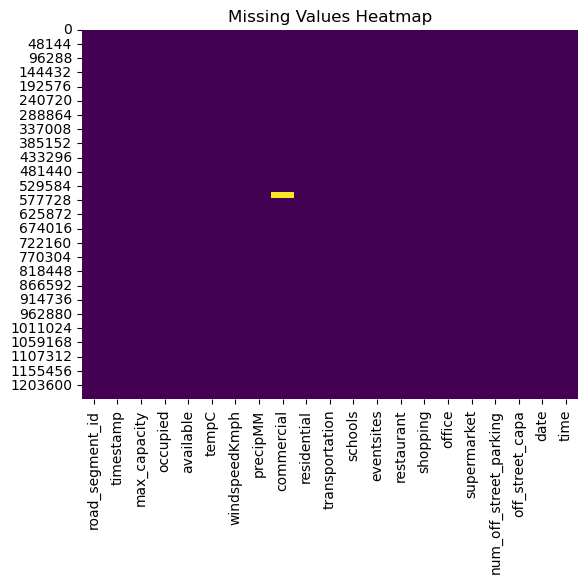

In [13]:
# Visualize missing values
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## 3.6 Outlier Detection

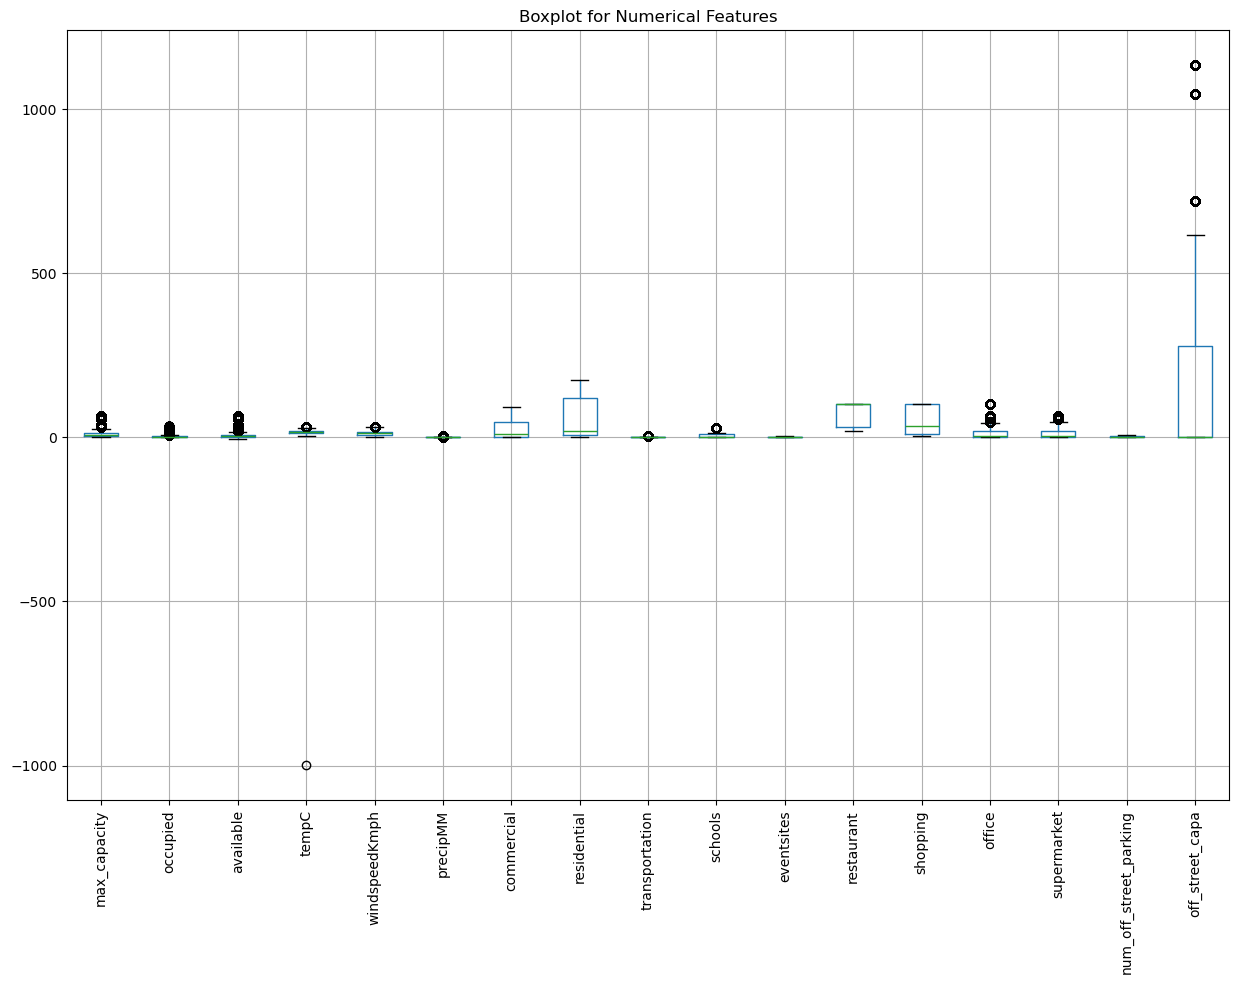

In [14]:
# Boxplot for numerical features to detect outliers
numerical_features = ['max_capacity', 'occupied', 'available', 'tempC', 'windspeedKmph', 'precipMM', 
                      'commercial', 'residential', 'transportation', 'schools', 'eventsites', 
                      'restaurant', 'shopping', 'office', 'supermarket', 'num_off_street_parking', 'off_street_capa']

plt.figure(figsize=(15, 10))
df[numerical_features].boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot for Numerical Features')
plt.show()

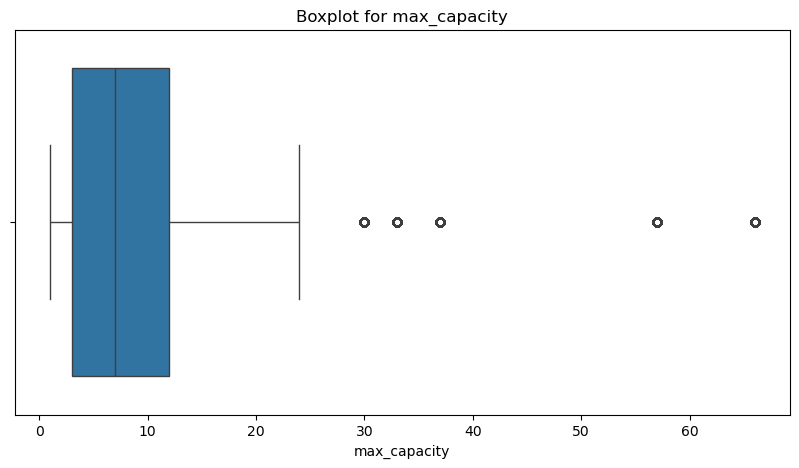

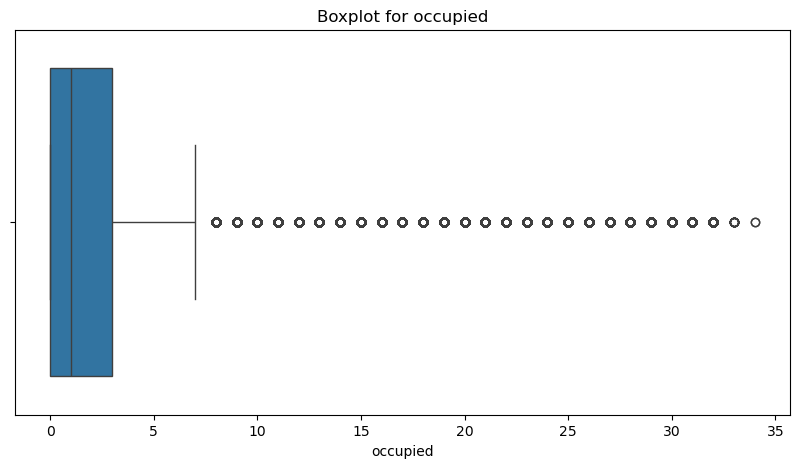

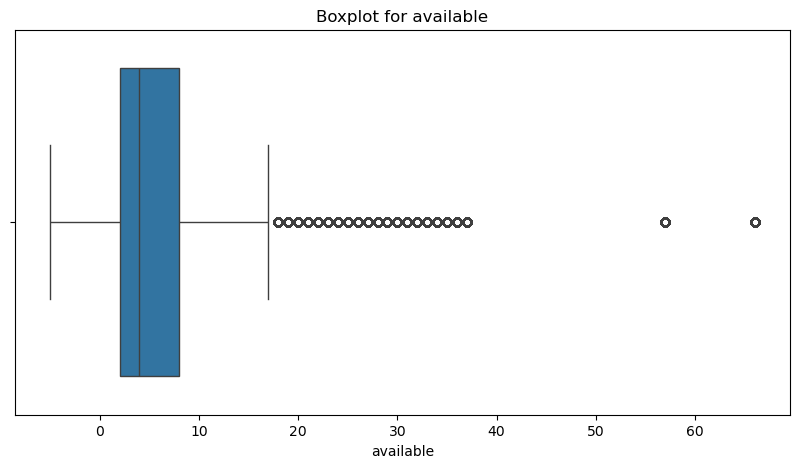

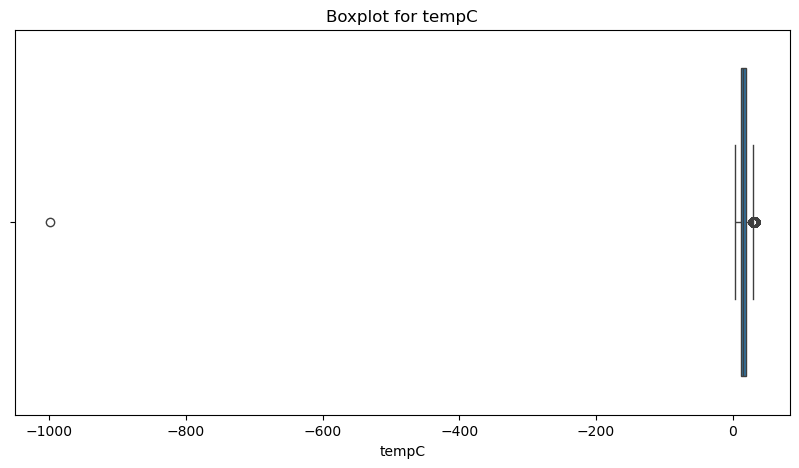

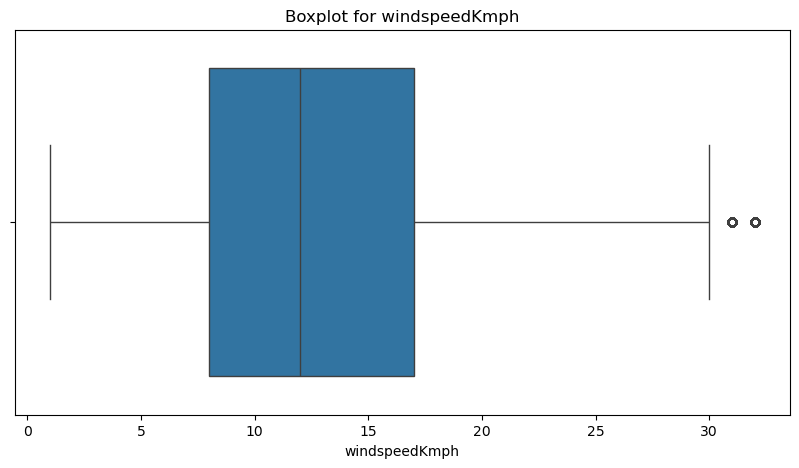

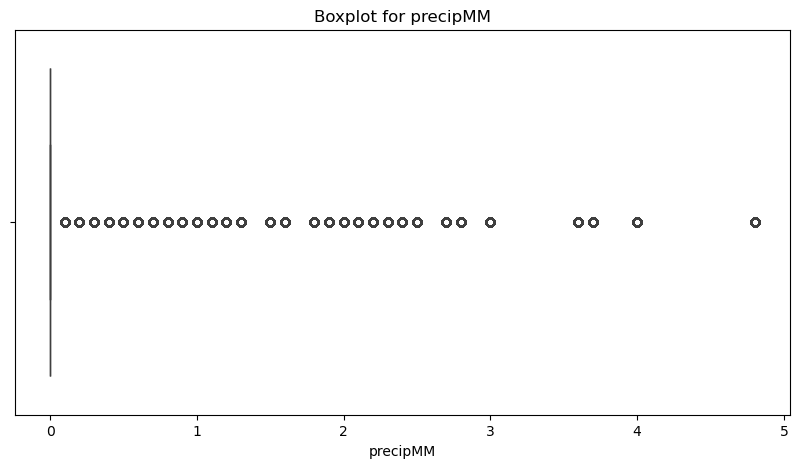

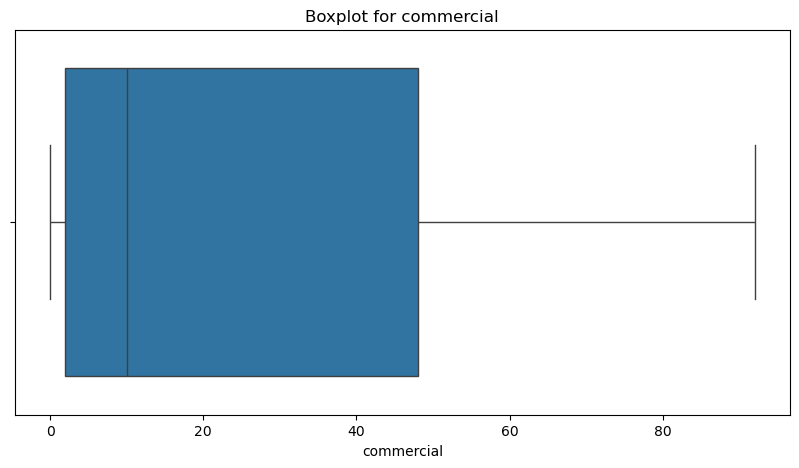

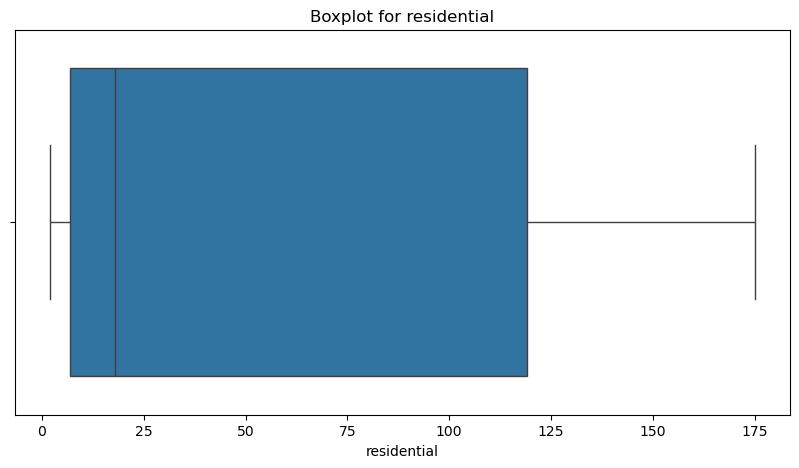

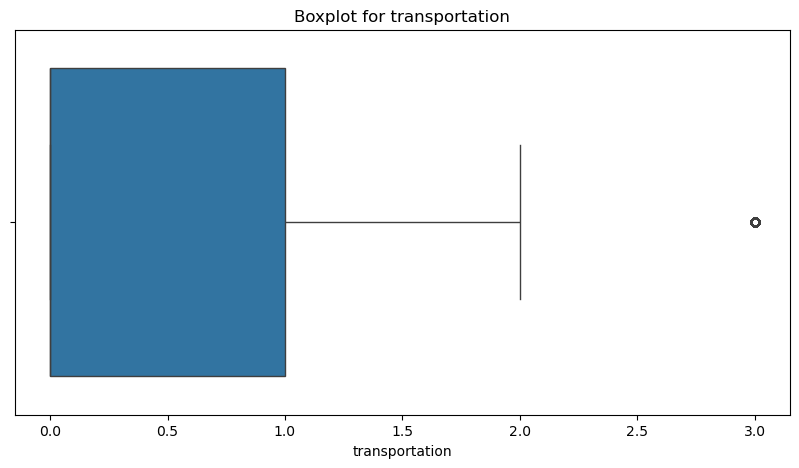

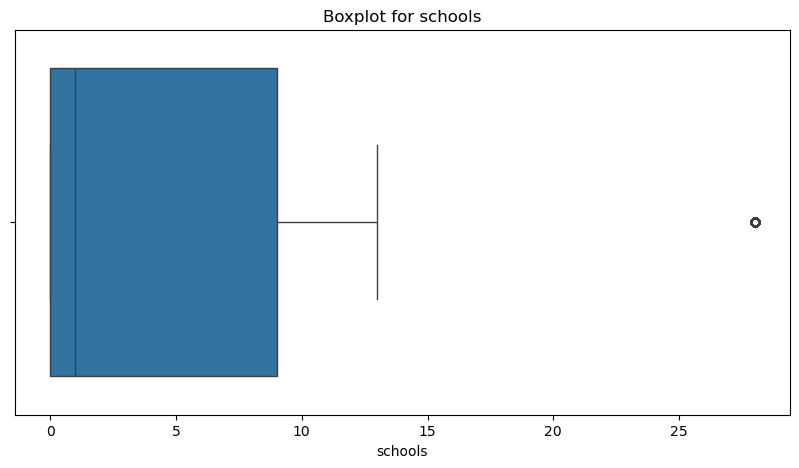

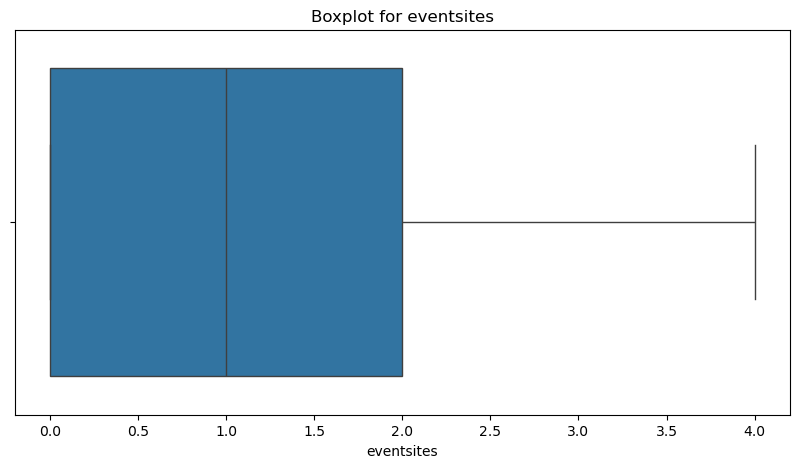

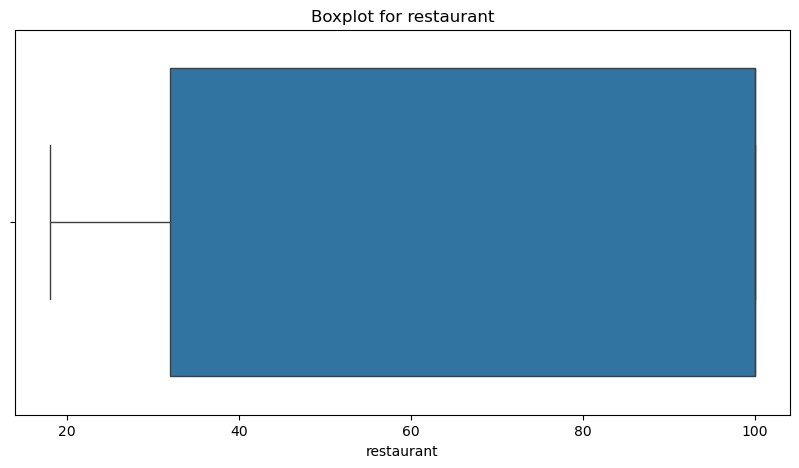

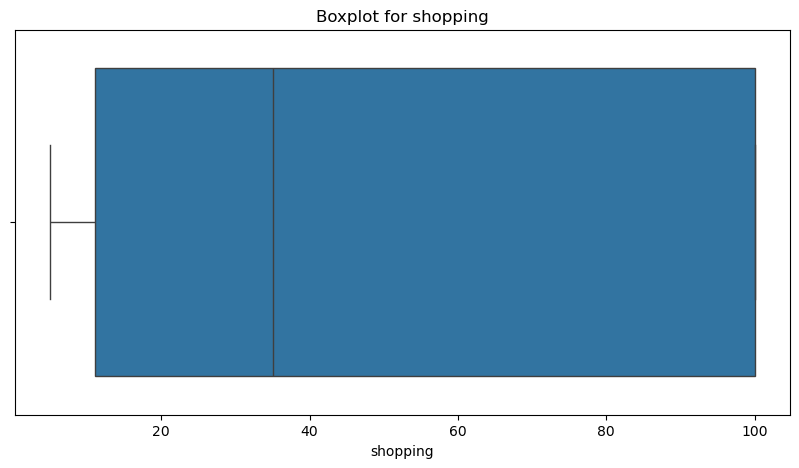

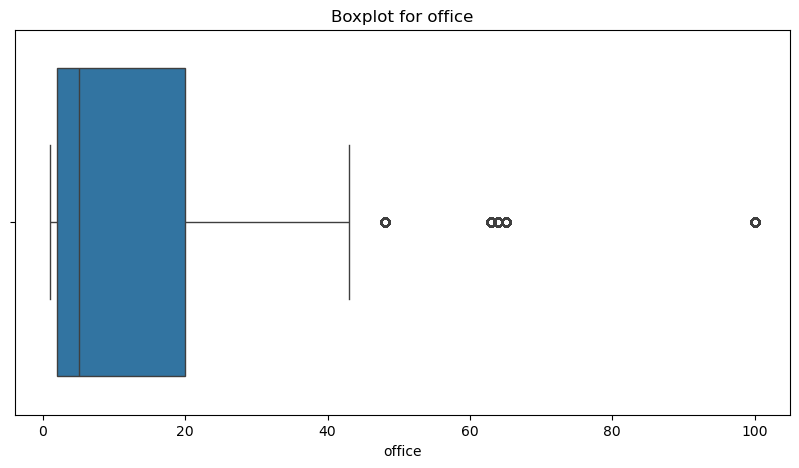

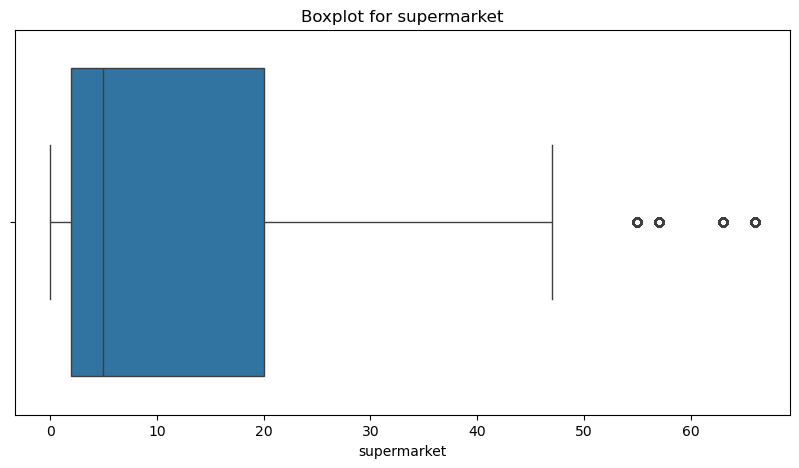

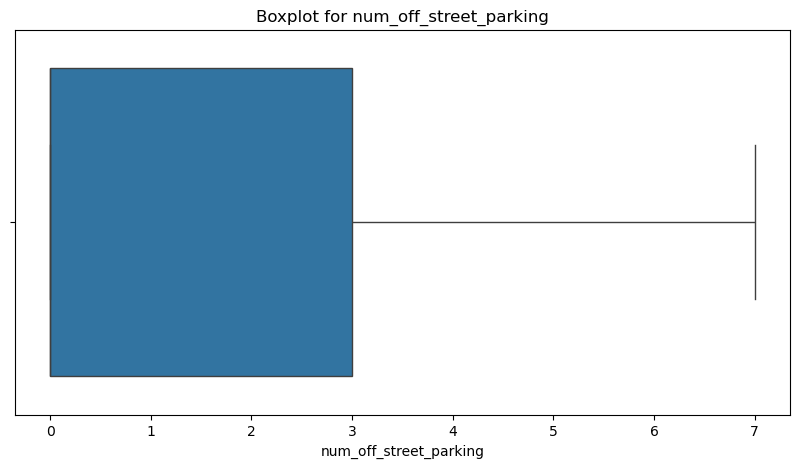

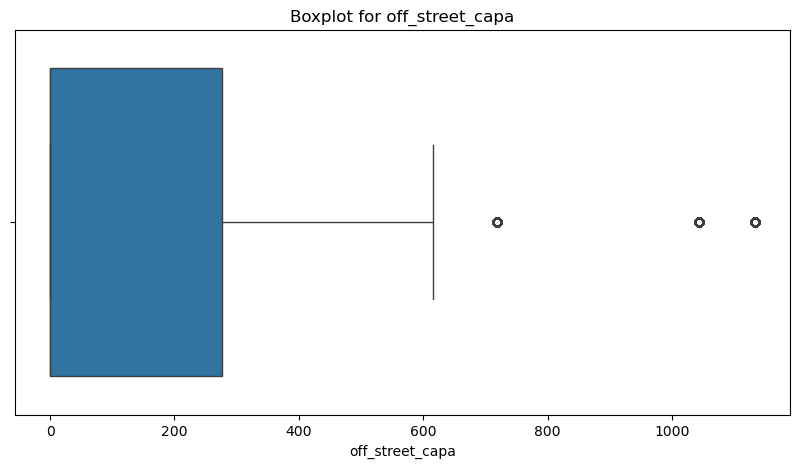

In [15]:
# Detailed boxplot for each feature
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()

In [16]:
def count_outliers(df):
    
    outliers = {}
    total_points = df.shape[0]
    
    for column in df.select_dtypes(include=['float64', 'int64']).columns:
        # Calculate Q1 and Q3 
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define outlier boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        num_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
        percentage_outliers = (num_outliers / total_points) * 100
        
        outliers[column] = [num_outliers, percentage_outliers]
    
    # Convert dictionary to df
    outliers_df = pd.DataFrame.from_dict(outliers, orient='index', columns=['Number of Outliers', 'Percentage of Outliers'])
    
    return outliers_df

In [17]:
outliers_df = count_outliers(df)
outliers_df

,Number of Outliers,Percentage of Outliers
road_segment_id,109800,8.771930
max_capacity,109800,8.771930
occupied,97081,7.755808
available,160035,12.785208
tempC,11629,0.929042
windspeedKmph,2052,0.163934
precipMM,284544,22.732240
commercial,0,0.000000
residential,0,0.000000
transportation,219600,17.543860


## 3.7 Data Quality issues

In [18]:
# Identifying negative values

def identify_negative_values(df, columns):
    negative_rows = df[(df[columns] < 0).any(axis=1)]
    return negative_rows

count_based_columns = ['max_capacity', 'occupied', 'available', 'windspeedKmph', 'precipMM', 
                      'commercial', 'residential', 'transportation', 'schools', 'eventsites', 
                      'restaurant', 'shopping', 'office', 'supermarket', 'num_off_street_parking', 'off_street_capa']

negative_values_df = identify_negative_values(df, count_based_columns)
negative_values_df

,road_segment_id,timestamp,max_capacity,occupied,available,tempC,windspeedKmph,precipMM,commercial,residential,...,schools,eventsites,restaurant,shopping,office,supermarket,num_off_street_parking,off_street_capa,date,time
7425,20026,2019-04-11 09:46:00,7,8,-1,14,4,0.0,58.0,32,...,4,2,100,100,65,63,4,462,2019-04-11,09:46:00
8178,20026,2019-04-15 12:32:00,7,8,-1,23,13,0.0,58.0,32,...,4,2,100,100,65,63,4,462,2019-04-15,12:32:00
12103,20026,2019-05-07 09:38:00,7,8,-1,13,15,0.0,58.0,32,...,4,2,100,100,65,63,4,462,2019-05-07,09:38:00
13917,20026,2019-05-17 10:45:00,7,9,-2,14,7,0.0,58.0,32,...,4,2,100,100,65,63,4,462,2019-05-17,10:45:00
16318,20026,2019-05-30 15:54:00,7,8,-1,11,18,0.0,58.0,32,...,4,2,100,100,65,63,4,462,2019-05-30,15:54:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228924,22942,2019-06-26 11:21:00,2,3,-1,12,8,0.0,20.0,10,...,0,1,100,100,15,22,5,1133,2019-06-26,11:21:00
1228966,22942,2019-06-26 14:52:00,2,3,-1,13,8,0.0,20.0,10,...,0,1,100,100,15,22,5,1133,2019-06-26,14:52:00
1229101,22942,2019-06-27 11:08:00,2,3,-1,13,17,0.0,20.0,10,...,0,1,100,100,15,22,5,1133,2019-06-27,11:08:00
1229165,22942,2019-06-27 16:27:00,2,3,-1,13,15,0.0,20.0,10,...,0,1,100,100,15,22,5,1133,2019-06-27,16:27:00


In [19]:
def count_negative_values(df, columns):
    negative_values = {}
    total_points = df.shape[0] 
    
    for column in columns:
        # Count negative values
        num_negative_values = (df[column] < 0).sum()
        percentage_negative_values = (num_negative_values / total_points) * 100
        
        negative_values[column] = [num_negative_values, percentage_negative_values]
    
    # Convert dictionary to df
    negative_values_df = pd.DataFrame.from_dict(negative_values, orient='index', columns=['Number of Negative Values', 'Percentage of Negative Values'])
    
    return negative_values_df

negative_values_df = count_negative_values(df, count_based_columns)
negative_values_df


,Number of Negative Values,Percentage of Negative Values
max_capacity,0,0.000000
occupied,0,0.000000
available,1353,0.108091
windspeedKmph,0,0.000000
precipMM,0,0.000000
commercial,0,0.000000
residential,0,0.000000
transportation,0,0.000000
schools,0,0.000000
eventsites,0,0.000000


## 3.8 Summary of Findings

In [84]:
data_issues = [
    {
        "Problem/Logical Issue": "Missing values",
        "Affected Variable/s": "commercial",
        "Number of Observations": 21960,
        "Potential Issues": "Missing values can lead to inaccurate analysis and model predictions.",
        "Handling Technique/s": "Imputation techniques such as filling missing values with mean, median, or using interpolation."
    },
    {
        "Problem/Logical Issue": "Outliers",
        "Affected Variable/s": "Available, precipMM, transportation, off_street_capa",
        "Number of Observations": "Various (see above)",
        "Potential Issues": "Outliers can distort the model training process and lead to poor predictions.",
        "Handling Technique/s": "Identifying and removing outliers using statistical methods like the cap value method."
    },
    {
        "Problem/Logical Issue": "Duplicates",
        "Affected Variable/s": "None",
        "Number of Observations": 0,
        "Potential Issues": "Multiple entries for the same road_segment_id and timestamp can skew results.",
        "Handling Technique/s": "Identifying and removing duplicate records to ensure each observation is unique."
    },
    {
        "Problem/Logical Issue": "Data quality issue 1",
        "Affected Variable/s": "occupied, available, max_capacity",
        "Number of Observations": "available: 1353",
        "Potential Issues": "sum of occupied and available should always equal max capacity.As a result of that we found 1,353 negative values in available.",
        "Handling Technique/s": "Replaced by 0"
    },
    {
        "Problem/Logical Issue": "Data quality issue 2",
        "Affected Variable/s": "tempC",
        "Number of Observations": "1",
        "Potential Issues": "mistake",
        "Handling Technique/s": "Replaced by 0/ mean"
    }
]


df_issues = pd.DataFrame(data_issues)
df_issues

,Problem/Logical Issue,Affected Variable/s,Number of Observations,Potential Issues,Handling Technique/s
0,Missing values,commercial,21960,Missing values can lead to inaccurate analysis...,Imputation techniques such as filling missing ...
1,Outliers,"Available, precipMM, transportation, off_stree...",Various (see above),Outliers can distort the model training proces...,Identifying and removing outliers using statis...
2,Duplicates,None,0,Multiple entries for the same road_segment_id ...,Identifying and removing duplicate records to ...
3,Data quality issue 1,"occupied, available, max_capacity",available: 1353,sum of occupied and available should always eq...,Replaced by 0
4,Data quality issue 2,tempC,1,mistake,Replaced by 0/ mean


# 4. Exploratory Data Analysis (EDA)
- Basic statistics
- Univariate Analysis
- Bivariate Analysis
- Multivariate Analysis

## 4.1 Basic Statistics

In [20]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Basic statistics
df.describe()

,road_segment_id,timestamp,max_capacity,occupied,available,tempC,windspeedKmph,precipMM,commercial,residential,transportation,schools,eventsites,restaurant,shopping,office,supermarket,num_off_street_parking,off_street_capa
count,1251720.00,1251720,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1229760.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00,1251720.00
mean,22097.02,2019-05-01 01:29:30.076503040,10.74,2.41,8.32,15.63,12.75,0.10,23.14,54.70,0.79,4.00,1.00,69.53,54.82,15.70,13.30,1.23,161.51
min,20026.00,2019-03-01 06:00:00,1.00,0.00,-5.00,-999.00,1.00,0.00,0.00,2.00,0.00,0.00,0.00,18.00,5.00,1.00,0.00,0.00,0.00
25%,21943.00,2019-03-31 13:31:15,3.00,0.00,2.00,12.00,8.00,0.00,2.00,7.00,0.00,0.00,0.00,32.00,11.00,2.00,2.00,0.00,0.00
50%,22277.00,2019-05-01 01:31:00,7.00,1.00,4.00,15.00,12.00,0.00,10.00,18.00,0.00,1.00,1.00,100.00,35.00,5.00,5.00,0.00,0.00
75%,22622.00,2019-05-31 13:26:30,12.00,3.00,8.00,19.00,17.00,0.00,48.00,119.00,1.00,9.00,2.00,100.00,100.00,20.00,20.00,3.00,277.00
max,23277.00,2019-06-30 20:59:00,66.00,34.00,66.00,32.00,32.00,4.80,92.00,175.00,3.00,28.00,4.00,100.00,100.00,100.00,66.00,7.00,1133.00
std,738.07,NaN,12.66,3.90,12.15,5.10,6.43,0.37,26.91,60.37,1.15,5.33,1.08,33.62,42.04,21.07,17.15,1.82,265.22


In [21]:
df['max_capacity'].sum()

13439520

In [22]:
df['road_segment_id'].nunique()

57

In [23]:
df.shape

(1251720, 21)

## 4.2 Univariate Analysis

In [24]:
# Histograms for each numeric column
def plot_histograms(df):
    df.hist(bins=10, figsize=(15, 10), color='skyblue', edgecolor='black')
    plt.suptitle('Univariate Analysis - Histograms of Numeric Features')
    plt.tight_layout()
    plt.show()

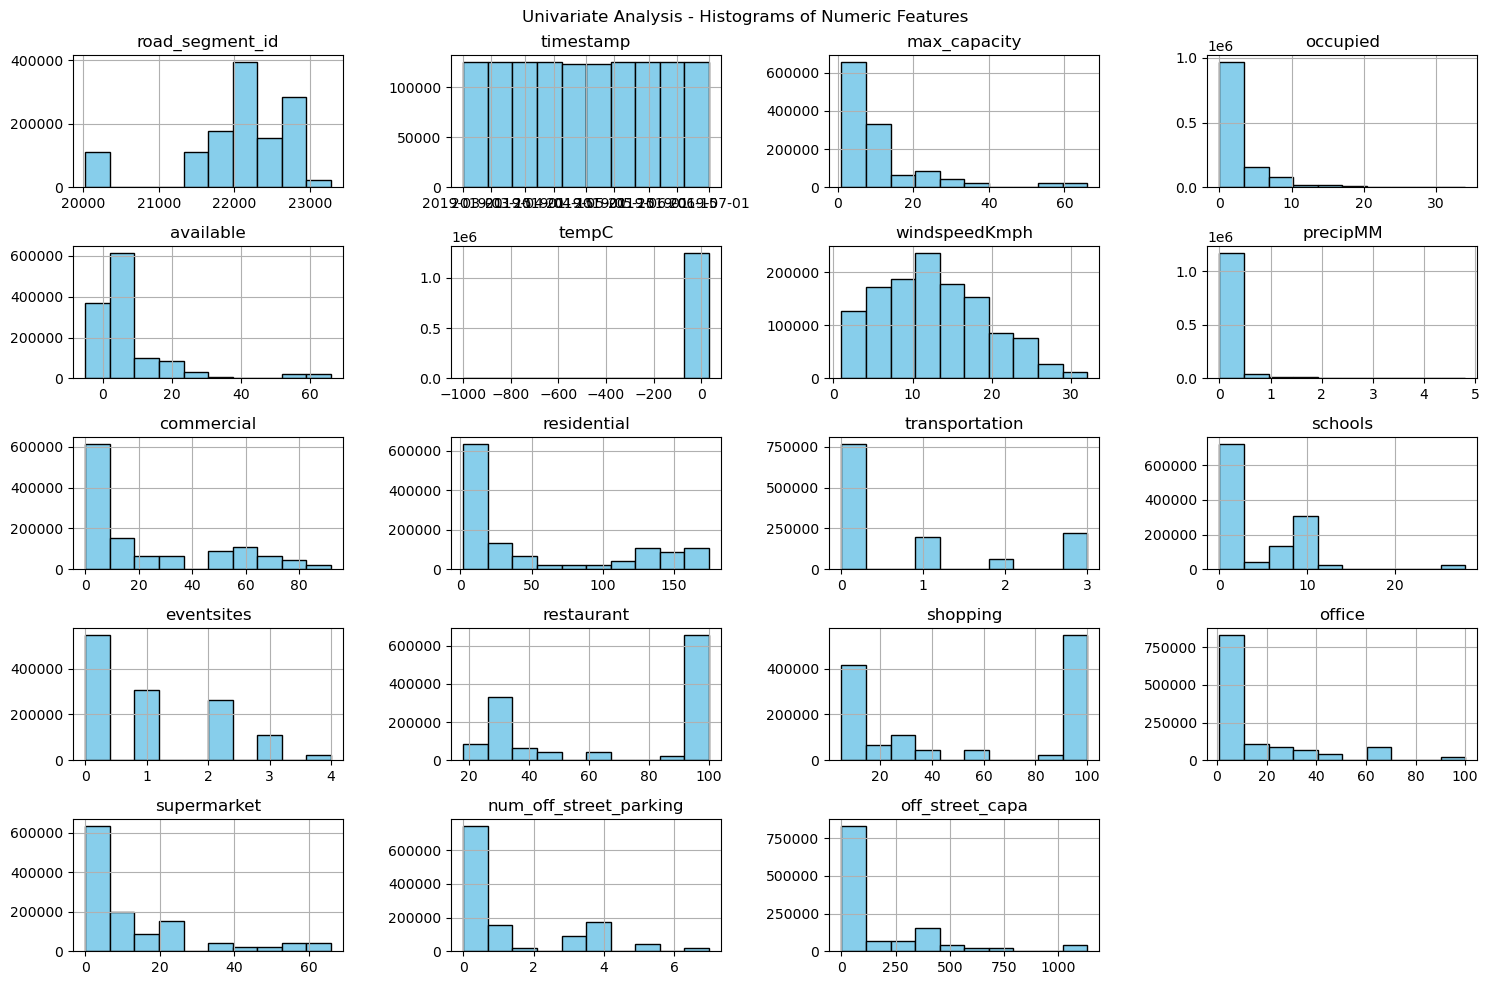

In [25]:
plot_histograms(df)

## 4.3 Bivariate Analysis

In [26]:
# Scatter plot matrix
def plot_scatter_matrix(df, features):
    sns.pairplot(df[features], plot_kws={'alpha':0.5, 's':30})
    plt.suptitle('Bivariate Analysis - Scatter Plot Matrix', y=1.02)
    plt.show()

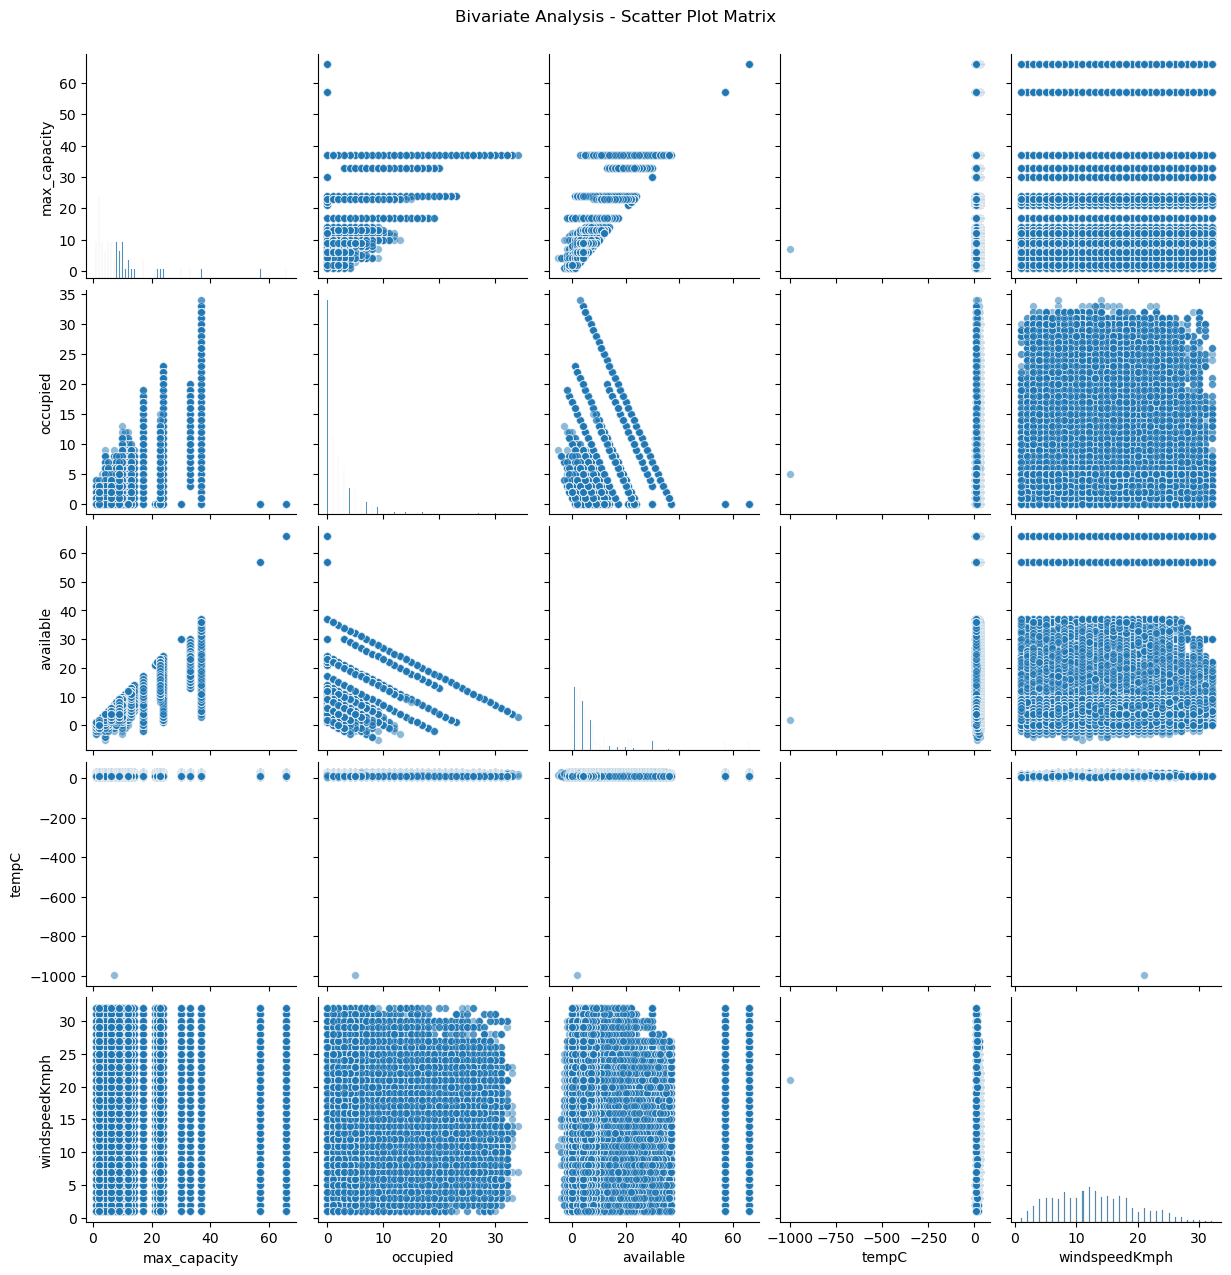

In [27]:
plot_scatter_matrix(df, ['max_capacity', 'occupied', 'available', 'tempC', 'windspeedKmph'])

C:\Users\lahir\AppData\Local\Temp\ipykernel_17740\307938723.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\lahir\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


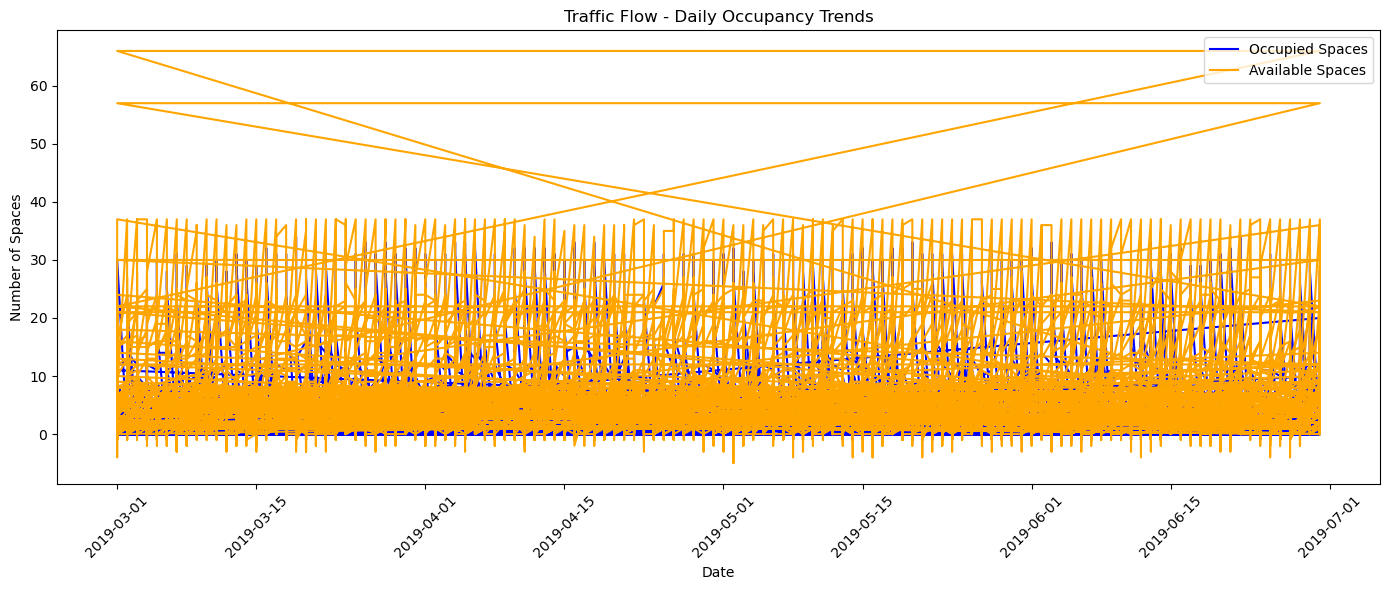

In [28]:
# Traffic Flow and Capacity Utilization
# Plot daily occupancy trends to identify peak and low times
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['occupied'], label='Occupied Spaces', color='blue')
plt.plot(df['date'], df['available'], label='Available Spaces', color='orange')
plt.xlabel('Date')
plt.ylabel('Number of Spaces')
plt.title('Traffic Flow - Daily Occupancy Trends')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cant interprete the above graph and therefore grouping the data

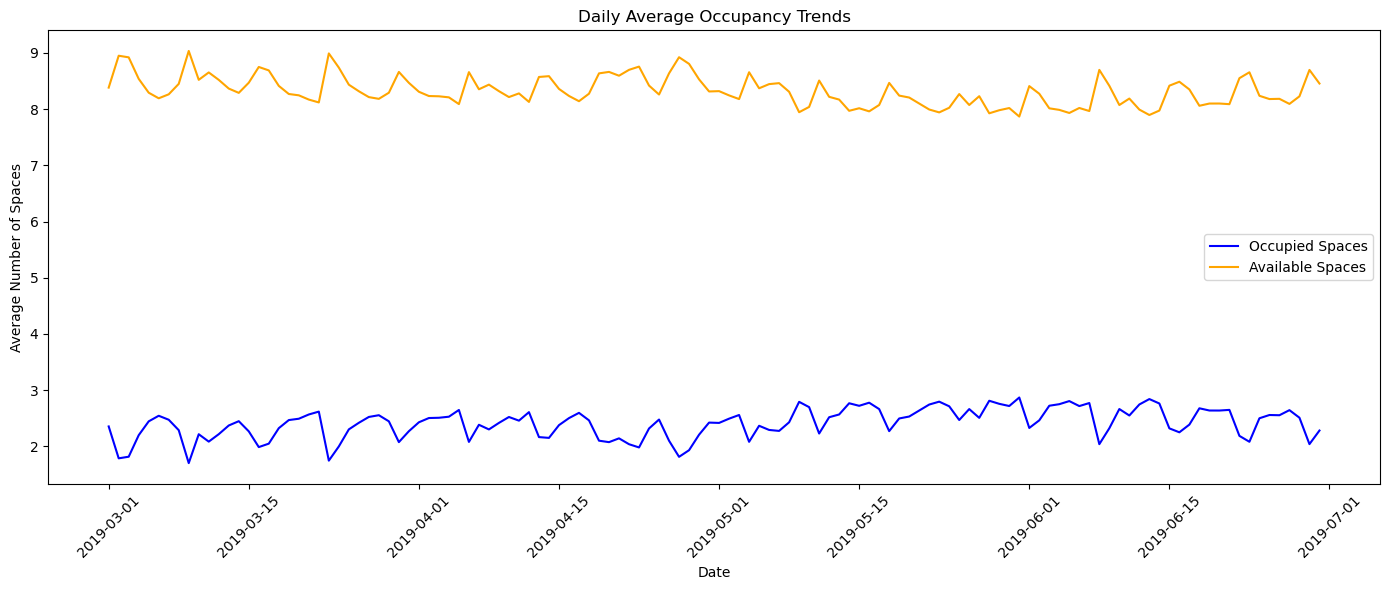

In [29]:
# Daily Average Occupancy Trends
# Grouping data by day to calculate daily averages of occupied and available spaces
df['date'] = df['timestamp'].dt.date
daily_avg = df.groupby('date').agg({'occupied': 'mean', 'available': 'mean'})

# Plot daily trends with the aggregated data
plt.figure(figsize=(14, 6))
plt.plot(daily_avg.index, daily_avg['occupied'], label='Occupied Spaces', color='blue')
plt.plot(daily_avg.index, daily_avg['available'], label='Available Spaces', color='orange')
plt.xlabel('Date')
plt.ylabel('Average Number of Spaces')
plt.title('Daily Average Occupancy Trends')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Temporally removing the outlier 
df2= df[df['tempC'] != -999]

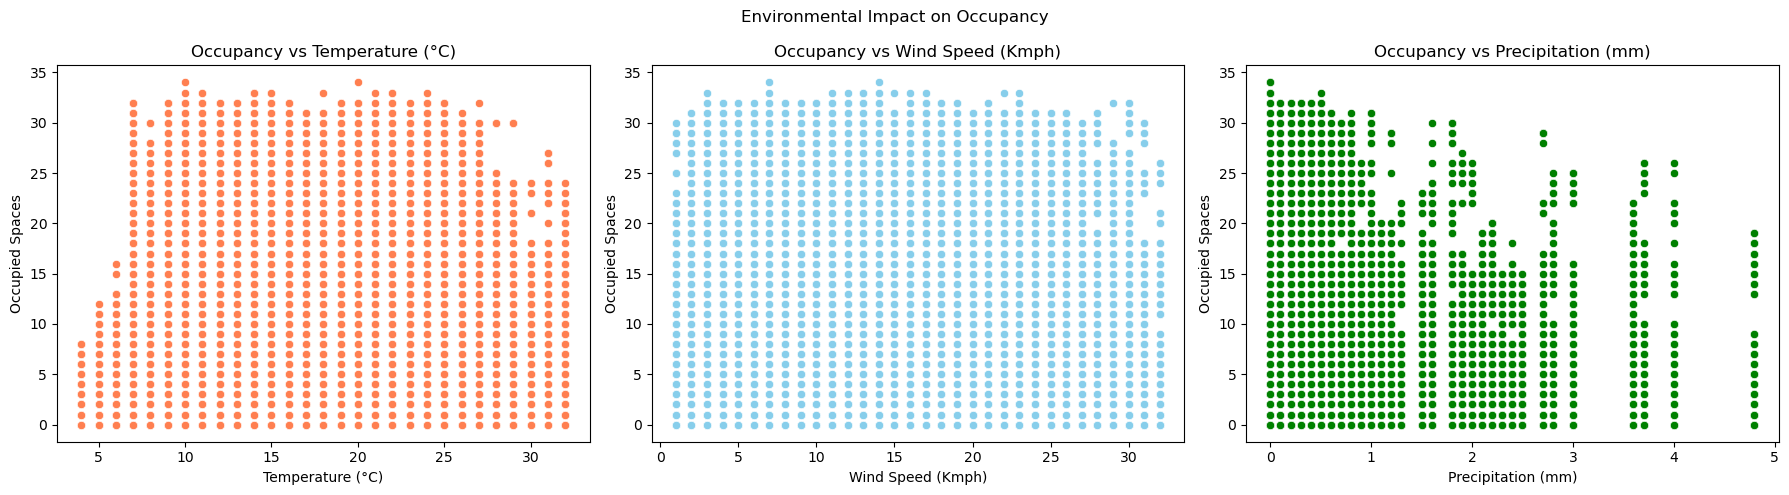

In [31]:
# Environmental Impact on Usage
# Scatter plot of occupancy vs temperature, wind speed, and precipitation
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=df2['tempC'], y=df2['occupied'], ax=axs[0], color='coral')
axs[0].set_title('Occupancy vs Temperature (°C)')
axs[0].set_xlabel('Temperature (°C)')
axs[0].set_ylabel('Occupied Spaces')

sns.scatterplot(x=df['windspeedKmph'], y=df['occupied'], ax=axs[1], color='skyblue')
axs[1].set_title('Occupancy vs Wind Speed (Kmph)')
axs[1].set_xlabel('Wind Speed (Kmph)')
axs[1].set_ylabel('Occupied Spaces')

sns.scatterplot(x=df['precipMM'], y=df['occupied'], ax=axs[2], color='green')
axs[2].set_title('Occupancy vs Precipitation (mm)')
axs[2].set_xlabel('Precipitation (mm)')
axs[2].set_ylabel('Occupied Spaces')

plt.suptitle('Environmental Impact on Occupancy')
plt.tight_layout()
plt.show()

C:\Users\lahir\AppData\Local\Temp\ipykernel_17740\2958170429.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\lahir\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


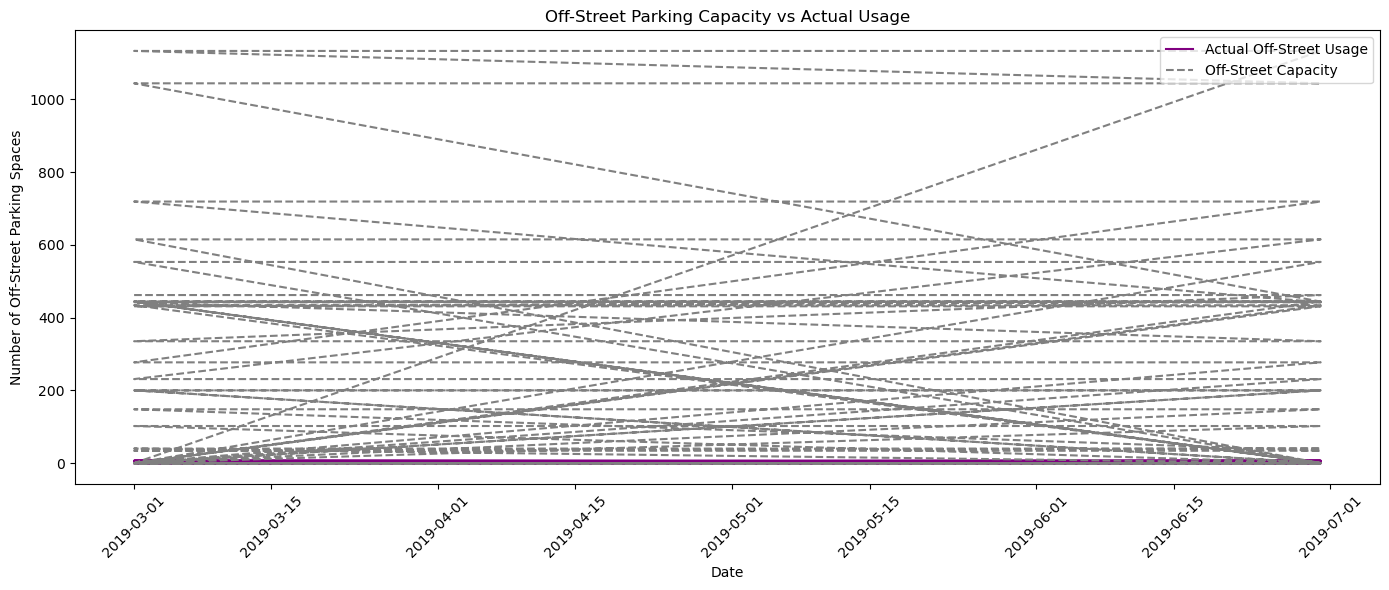

In [32]:
# Off-street Parking Capacity vs Occupancy
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['num_off_street_parking'], label='Actual Off-Street Usage', color='purple')
plt.plot(df['date'], df['off_street_capa'], label='Off-Street Capacity', color='gray', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Number of Off-Street Parking Spaces')
plt.title('Off-Street Parking Capacity vs Actual Usage')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

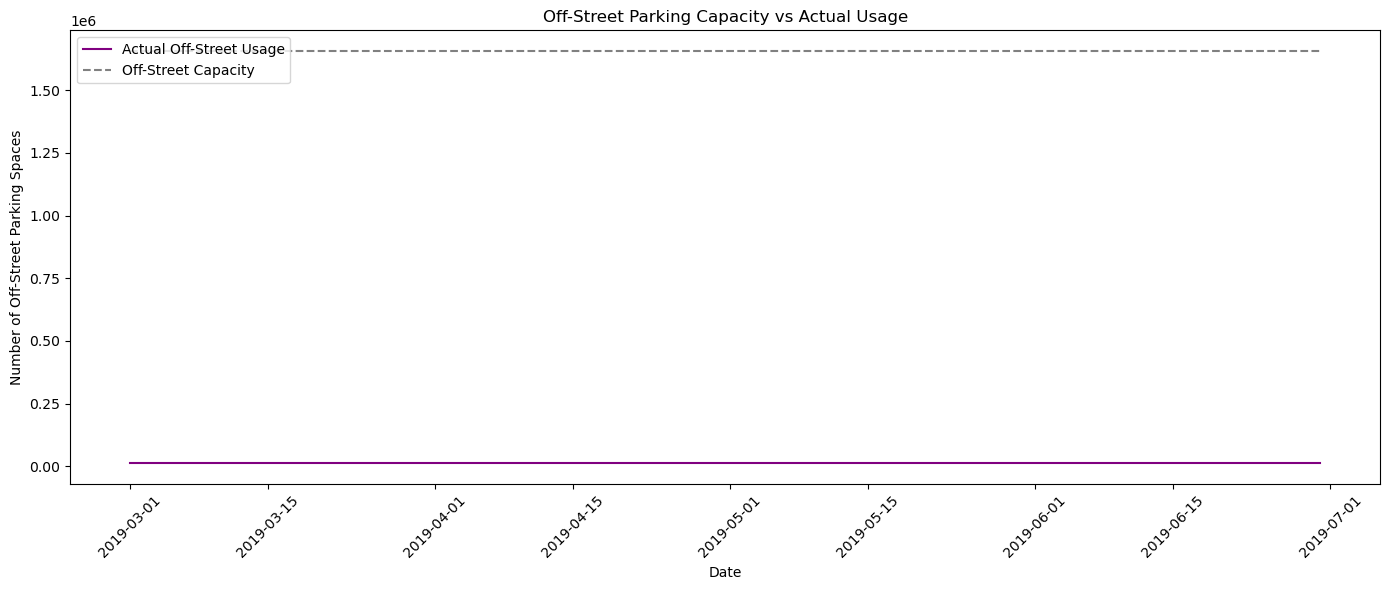

In [33]:
# Off-Street Parking Capacity vs Actual Usage
# Aggregate data by date (for example, by summing up the 'num_off_street_parking' and 'off_street_capa')
daily_data = df.groupby('date').agg({
    'num_off_street_parking': 'sum', 
    'off_street_capa': 'sum'
}).reset_index()

# Plot the aggregated data
plt.figure(figsize=(14, 6))
plt.plot(daily_data['date'], daily_data['num_off_street_parking'], label='Actual Off-Street Usage', color='purple')
plt.plot(daily_data['date'], daily_data['off_street_capa'], label='Off-Street Capacity', color='gray', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Number of Off-Street Parking Spaces')
plt.title('Off-Street Parking Capacity vs Actual Usage')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [34]:
# Check the unique date counts
date_counts = df['date'].value_counts()
print("Unique date counts:\n", date_counts)

Unique date counts:
 date
2019-03-01    10260
2019-05-31    10260
2019-05-29    10260
2019-05-28    10260
2019-05-27    10260
              ...  
2019-04-06    10260
2019-04-05    10260
2019-04-04    10260
2019-04-03    10260
2019-06-30    10260
Name: count, Length: 122, dtype: int64


In [35]:
# Define the time range for events 
# Assume events occur between 18:00 and 20:59
start_time = pd.to_datetime('18:00:00').time()
end_time = pd.to_datetime('20:59:00').time()

# Filter the DataFrame for times between 18:00 and 20:59
df_events = df[(df['time'] >= start_time) & (df['time'] <= end_time)]
df_events

,road_segment_id,timestamp,max_capacity,occupied,available,tempC,windspeedKmph,precipMM,commercial,residential,...,schools,eventsites,restaurant,shopping,office,supermarket,num_off_street_parking,off_street_capa,date,time
144,20026,2019-03-01 18:03:00,7,2,5,29,9,0.00,58.00,32,...,4,2,100,100,65,63,4,462,2019-03-01,18:03:00
145,20026,2019-03-01 18:05:00,7,2,5,29,9,0.00,58.00,32,...,4,2,100,100,65,63,4,462,2019-03-01,18:05:00
146,20026,2019-03-01 18:12:00,7,0,7,29,9,0.00,58.00,32,...,4,2,100,100,65,63,4,462,2019-03-01,18:12:00
147,20026,2019-03-01 18:18:00,7,0,7,29,9,0.00,58.00,32,...,4,2,100,100,65,63,4,462,2019-03-01,18:18:00
148,20026,2019-03-01 18:22:00,7,1,6,29,9,0.00,58.00,32,...,4,2,100,100,65,63,4,462,2019-03-01,18:22:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251715,23277,2019-06-30 20:36:00,9,5,4,9,18,0.00,11.00,16,...,1,1,100,100,2,7,0,0,2019-06-30,20:36:00
1251716,23277,2019-06-30 20:44:00,9,5,4,9,18,0.00,11.00,16,...,1,1,100,100,2,7,0,0,2019-06-30,20:44:00
1251717,23277,2019-06-30 20:46:00,9,5,4,9,18,0.00,11.00,16,...,1,1,100,100,2,7,0,0,2019-06-30,20:46:00
1251718,23277,2019-06-30 20:52:00,9,5,4,9,18,0.00,11.00,16,...,1,1,100,100,2,7,0,0,2019-06-30,20:52:00


In [36]:
# Event Impacts and Temporal Patterns Analysis

# Create a column to simulate events; assume events occur during specific hours across days
df['is_event_time'] = df['time'].apply(lambda t: 1 if t.hour in [18, 19, 20] else 0)  # Events in the evening

C:\Users\lahir\AppData\Local\Temp\ipykernel_17740\1450093152.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_vs_non_event.index, y=event_vs_non_event.values, palette='pastel')


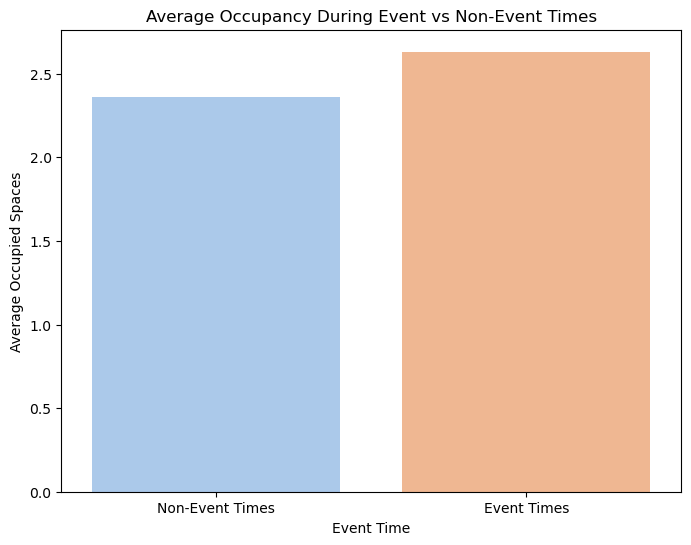

In [37]:
# Average Occupancy During Event vs Non-Event Times
# Calculate average occupancy for event and non-event times
event_vs_non_event = df.groupby('is_event_time')['occupied'].mean()
event_vs_non_event.index = ['Non-Event Times', 'Event Times']

# Plot event vs non-event time occupancy
plt.figure(figsize=(8, 6))
sns.barplot(x=event_vs_non_event.index, y=event_vs_non_event.values, palette='pastel')
plt.xlabel('Event Time')
plt.ylabel('Average Occupied Spaces')
plt.title('Average Occupancy During Event vs Non-Event Times')
plt.show()

C:\Users\lahir\AppData\Local\Temp\ipykernel_17740\3574020592.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_occupancy_by_day.index, y=avg_occupancy_by_day.values, palette='viridis')


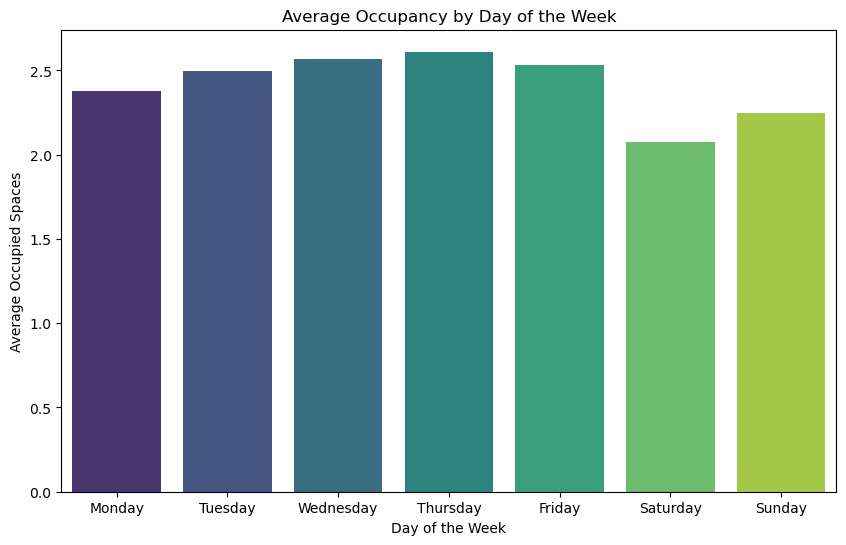

In [38]:
# Average Occupancy by Day of the Week
# Convert 'timestamp' to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Temporal Patterns: Weekly and Daily Trends
# Extract day of the week and hour of the day for temporal pattern analysis
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour_of_day'] = df['timestamp'].dt.hour

# Average occupancy by day of the week
avg_occupancy_by_day = df.groupby('day_of_week')['occupied'].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_occupancy_by_day.index, y=avg_occupancy_by_day.values, palette='viridis')
plt.xlabel('Day of the Week')
plt.ylabel('Average Occupied Spaces')
plt.title('Average Occupancy by Day of the Week')
plt.show()

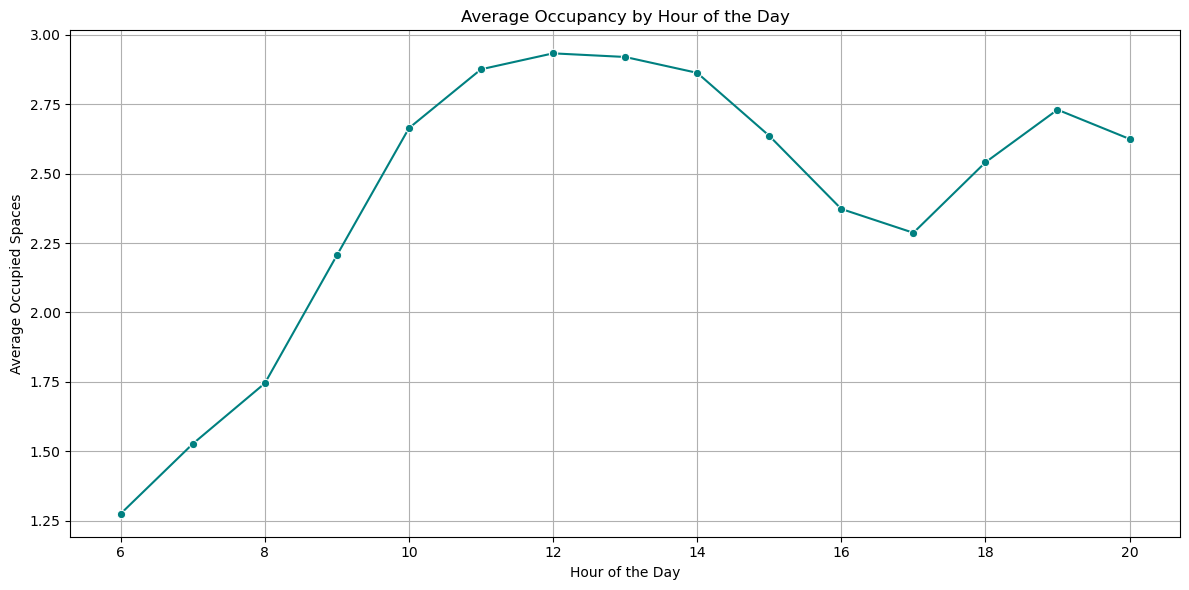

In [39]:
# Average occupancy by hour of the day
avg_occupancy_by_hour = df.groupby('hour_of_day')['occupied'].mean()

# Plot average occupancy by hour of the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_occupancy_by_hour.index, y=avg_occupancy_by_hour.values, marker='o', color='teal')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Occupied Spaces')
plt.title('Average Occupancy by Hour of the Day')
plt.grid()
plt.tight_layout()
plt.show()

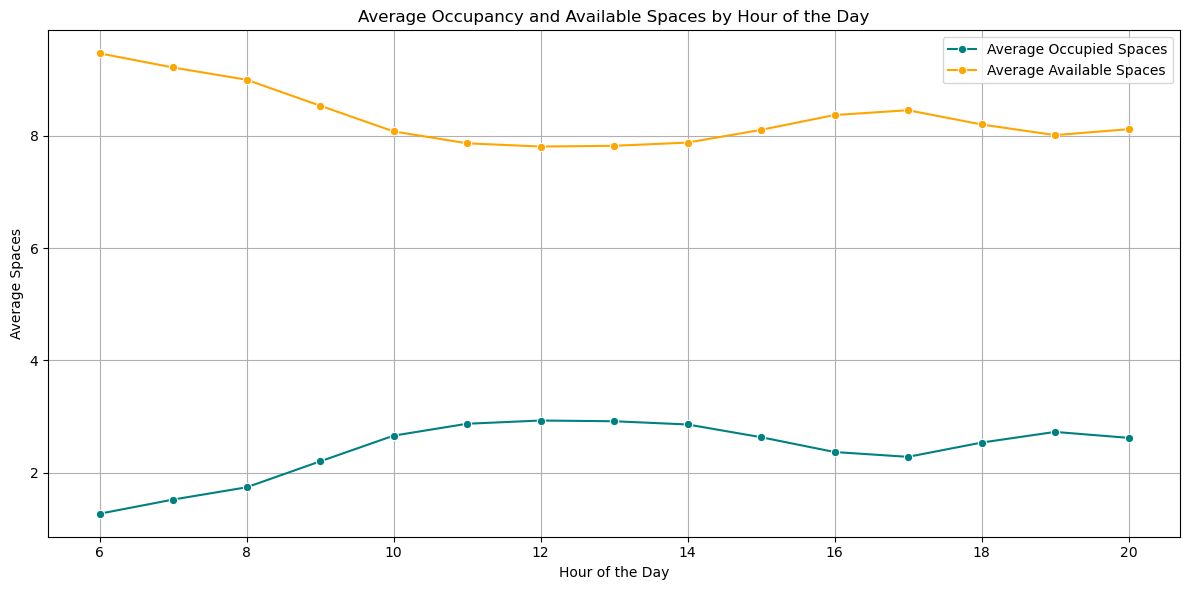

In [40]:
# Calculate average occupancy and available spaces by hour of the day
avg_occupancy_by_hour = df.groupby('hour_of_day')['occupied'].mean()
avg_available_by_hour = df.groupby('hour_of_day')['available'].mean()

# Plot average occupancy and available spaces by hour of the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_occupancy_by_hour.index, y=avg_occupancy_by_hour.values, marker='o', color='teal', label='Average Occupied Spaces')
sns.lineplot(x=avg_available_by_hour.index, y=avg_available_by_hour.values, marker='o', color='orange', label='Average Available Spaces')

# Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Spaces')
plt.title('Average Occupancy and Available Spaces by Hour of the Day')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

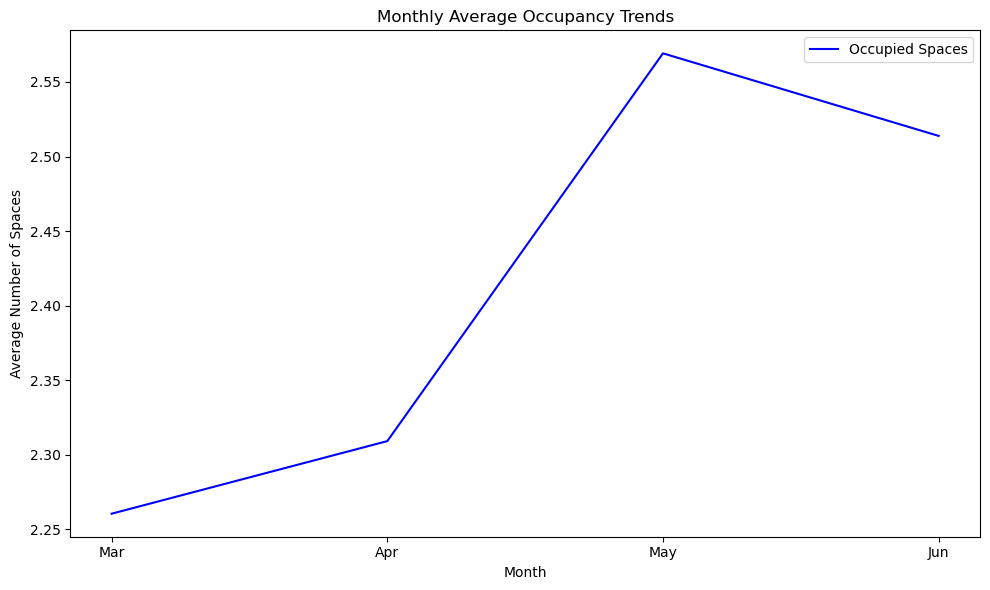

In [44]:
# Monthly Average Occupancy Trends
df['month'] = df['timestamp'].dt.month
monthly_avg = df.groupby('month').agg({'occupied': 'mean', 'available': 'mean'})
month_labels = {3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun'}

plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg['occupied'], label='Occupied Spaces', color='blue')
#plt.plot(monthly_avg.index, monthly_avg['available'], label='Available Spaces', color='orange')
plt.xlabel('Month')
plt.ylabel('Average Number of Spaces')
plt.title('Monthly Average Occupancy Trends')
plt.legend()
plt.xticks(monthly_avg.index, [month_labels[m] for m in monthly_avg.index])
plt.tight_layout()
plt.show()

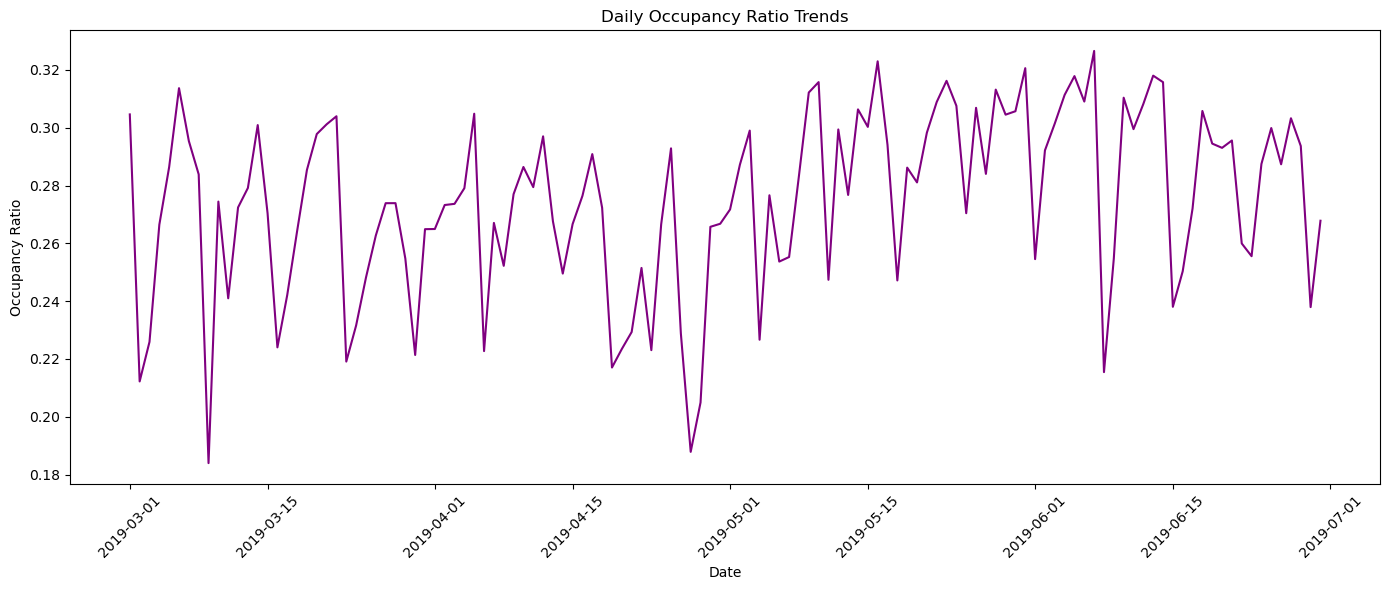

In [45]:
# Daily Occupancy Ratio Trends
# Calculate occupancy to availability ratio
df['occupancy_ratio'] = df['occupied'] / (df['occupied'] + df['available'])

# Group by day and calculate daily occupancy ratio
daily_ratio = df.groupby('date')['occupancy_ratio'].mean()

# Plot the daily occupancy ratio trend
plt.figure(figsize=(14, 6))
plt.plot(daily_ratio.index, daily_ratio.values, label='Occupancy Ratio', color='purple')
plt.xlabel('Date')
plt.ylabel('Occupancy Ratio')
plt.title('Daily Occupancy Ratio Trends')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

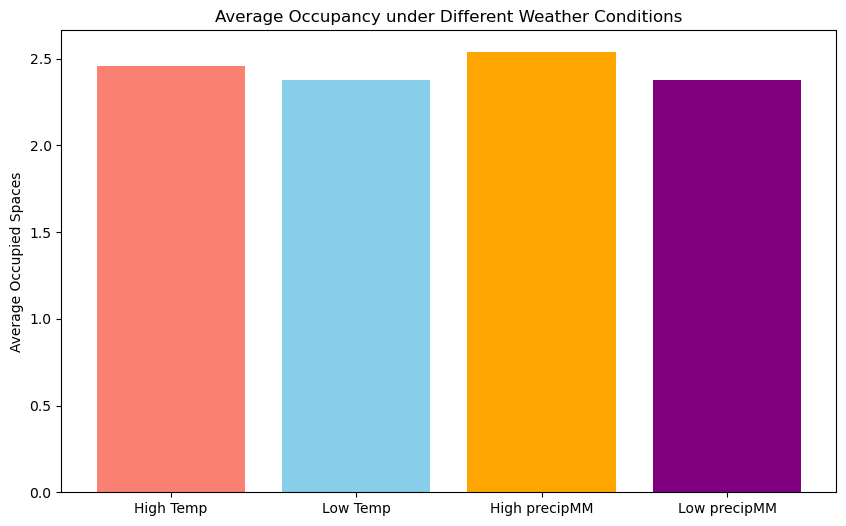

In [47]:
# Average Occupancy under Different Weather Conditions
# Divide data into high and low temperature/wind groups
high_temp = df[df['tempC'] > df['tempC'].median()]
low_temp = df[df['tempC'] <= df['tempC'].median()]
high_wind = df[df['precipMM'] > df['precipMM'].median()]
low_wind = df[df['precipMM'] <= df['precipMM'].median()]

# Plot comparison of occupancy under different conditions
plt.figure(figsize=(10, 6))
plt.bar(['High Temp', 'Low Temp', 'High precipMM', 'Low precipMM'],
        [high_temp['occupied'].mean(), low_temp['occupied'].mean(), high_wind['occupied'].mean(), low_wind['occupied'].mean()],
        color=['salmon', 'skyblue', 'orange', 'purple'])
plt.ylabel('Average Occupied Spaces')
plt.title('Average Occupancy under Different Weather Conditions')
plt.show()


In [50]:
df.columns

Index(['road_segment_id', 'timestamp', 'max_capacity', 'occupied', 'available',
       'tempC', 'windspeedKmph', 'precipMM', 'commercial', 'residential',
       'transportation', 'schools', 'eventsites', 'restaurant', 'shopping',
       'office', 'supermarket', 'num_off_street_parking', 'off_street_capa',
       'date', 'time', 'is_event_time', 'day_of_week', 'hour_of_day', 'month',
       'occupancy_ratio'],
      dtype='object')

In [ ]:
## 4.4 Multivariate Analysis

In [48]:
# Heatmap for correlation
def plot_correlation_heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Multivariate Analysis - Correlation Heatmap')
    plt.show()

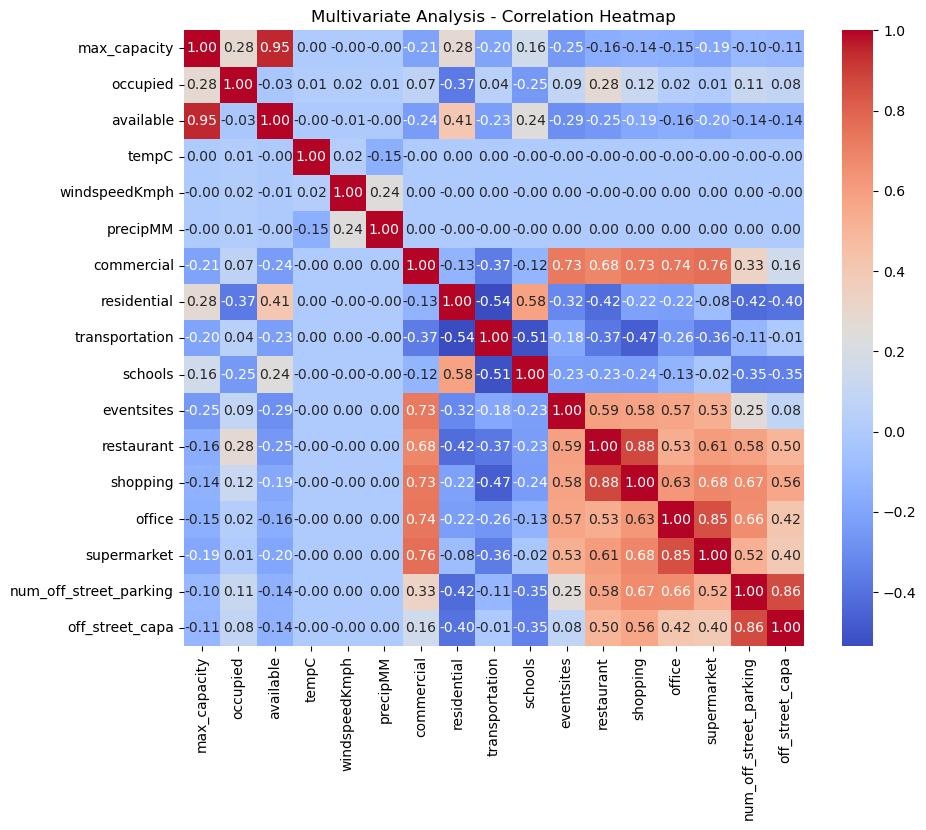

In [57]:
plot_correlation_heatmap(df.iloc[:, 2:-7]) # Considering only the relevant features

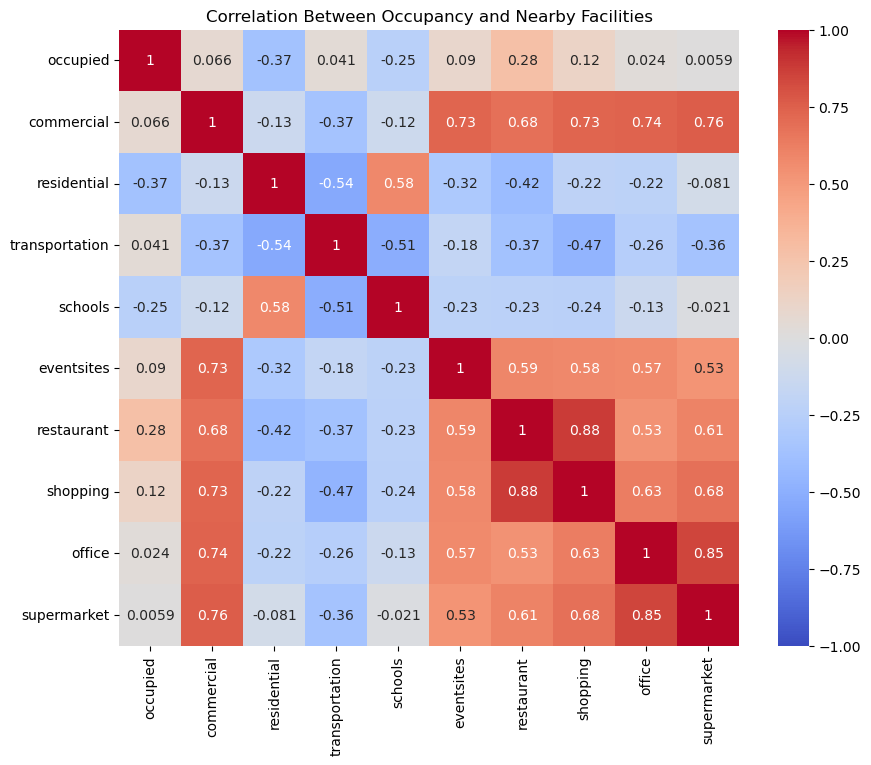

In [58]:
# Analyzing the impact of nearby facilities and off-street parking on occupancy

# Correlation heatmap
plt.figure(figsize=(10, 8))
facilities_cols = ['commercial', 'residential', 'transportation', 'schools', 'eventsites', 
                   'restaurant', 'shopping', 'office', 'supermarket']
correlation_matrix = df[['occupied'] + facilities_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Occupancy and Nearby Facilities')
plt.show()

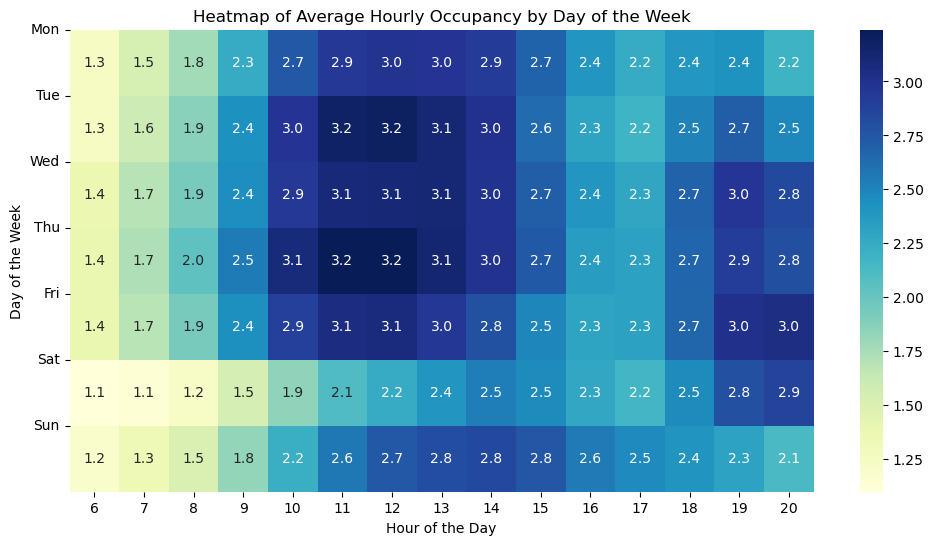

In [59]:
# Heatmap of Average Hourly Occupancy by Day of the Week
# Create a pivot table to show average occupancy per hour for each day of the week
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour
hourly_weekday_pivot = df.pivot_table(values='occupied', index='day_of_week', columns='hour', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(hourly_weekday_pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Heatmap of Average Hourly Occupancy by Day of the Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


In [60]:
# Temporal Analysis 
# Line plot for occupied vs available over time
def plot_temporal_trends(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['occupied'], label='Occupied', color='blue')
    plt.plot(df['date'], df['available'], label='Available', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title('Temporal Analysis - Occupied vs Available Over Date')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

C:\Users\lahir\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


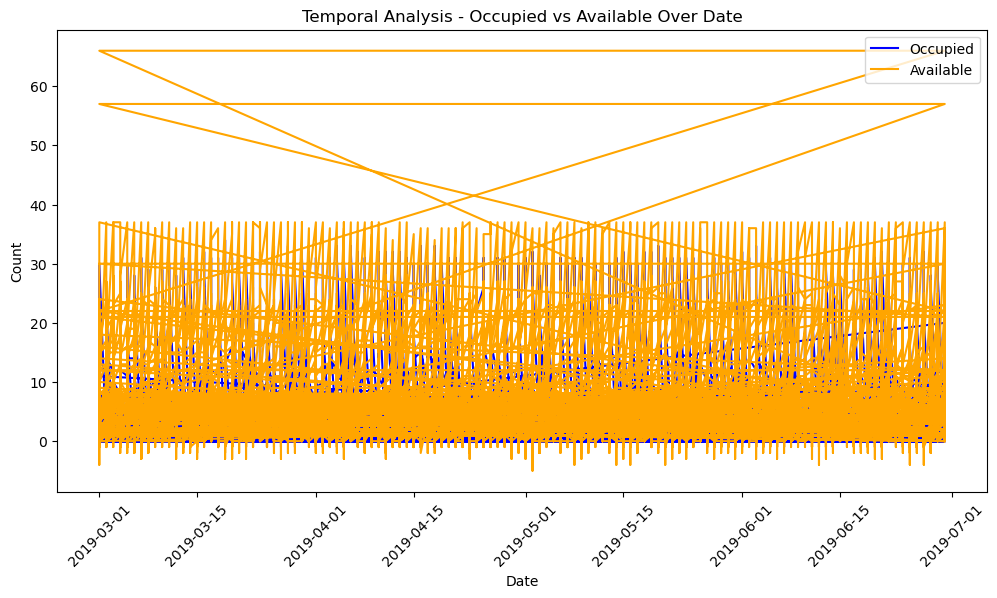

In [61]:
plot_temporal_trends(df)

C:\Users\lahir\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


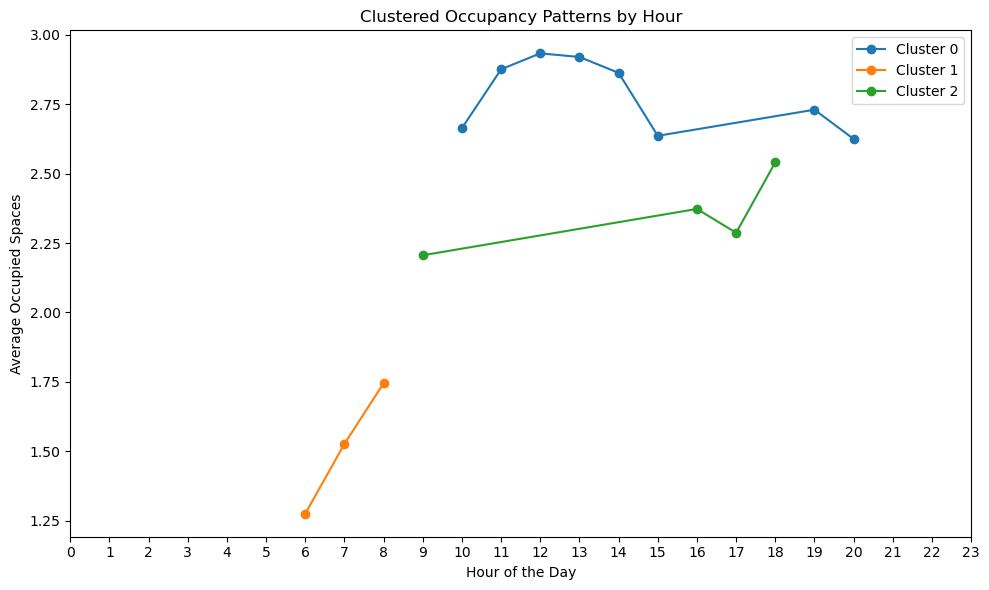

In [62]:
# Cluster Analysis

# Prepare data for clustering by averaging occupancy at each hour of the day
hourly_pattern = df.groupby('hour_of_day').agg({'occupied': 'mean', 'available': 'mean'})

# Standardize data for clustering
scaler = StandardScaler()
hourly_pattern_scaled = scaler.fit_transform(hourly_pattern)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(hourly_pattern_scaled)
hourly_pattern['cluster'] = kmeans.labels_

# Plot hourly patterns by cluster
plt.figure(figsize=(10, 6))
for cluster in range(3):
    subset = hourly_pattern[hourly_pattern['cluster'] == cluster]
    plt.plot(subset.index, subset['occupied'], label=f'Cluster {cluster}', marker='o')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Occupied Spaces')
plt.title('Clustered Occupancy Patterns by Hour')
plt.legend()
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


# 5. Model Training and Evaluation
I ran several experiments with different data preprocessing techniques, as shown in the results graph below. I conducted the experiments without feature engineering, by selecting specific features, by creating new features using lag features and rolling aggregates for max capacity and occupancy, and finally, by performing feature engineering and treating outliers.

In [67]:
# Placeholder for results tracking
results = []

# Define a function to train and evaluate a model
def run_experiment(df, features, target, attempt_name, top_n=10):
    # Splitting the data
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Normalization using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Model training
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Predictions
    predictions = model.predict(X_test)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    # Print metrics
    print(f"Attempt: {attempt_name}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"R-squared: {r2}")

    # Append metrics to results list
    results.append({
        'Attempt': attempt_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
        })
    
    # Get feature importances
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Select the top N most important features
    top_features = importance_df.head(top_n)

    # Plot top important features
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(f'Top {top_n} Important Features for {attempt_name}')
    plt.gca().invert_yaxis()
    plt.show()

Attempt: Attempt 1
Mean Absolute Error: 1.0882860783561816
Root Mean Squared Error: 2.089467644245773
R-squared: 0.9151142918809467


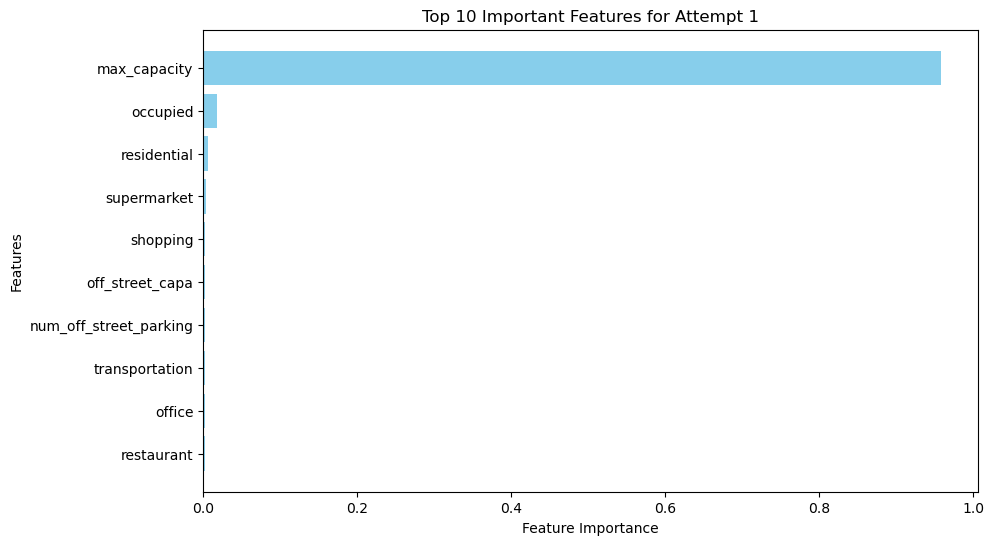

In [68]:
# Attempt 1 - Selecting all the features and without doing feature engineering
attempt1 = ['max_capacity', 'occupied', 'tempC',
       'windspeedKmph', 'precipMM', 'commercial', 'residential',
       'transportation', 'schools', 'eventsites', 'restaurant', 'shopping',
       'office', 'supermarket', 'num_off_street_parking', 'off_street_capa']
run_experiment(df, attempt1, 'available', "Attempt 1")

C:\Users\lahir\AppData\Local\Temp\ipykernel_17740\1126651581.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['commercial'].fillna(df['commercial'].median(), inplace=True)
C:\Users\lahir\AppData\Local\Temp\ipykernel_17740\1126651581.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

Attempt: Attempt 2
Mean Absolute Error: 7.331413768012332
Root Mean Squared Error: 8.661392299071043
R-squared: -0.4586998063368364


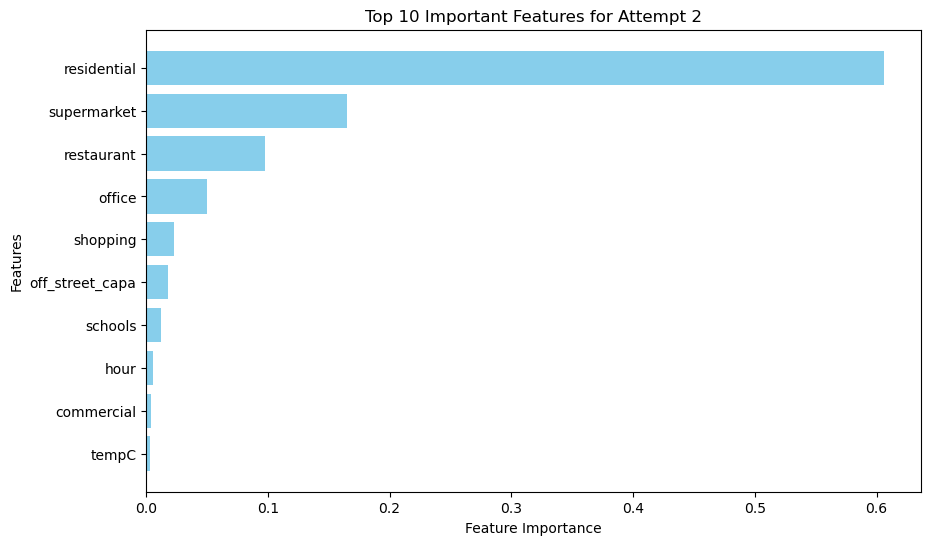

In [69]:
# Attempt 2 - Feature Engineering, Preprocessing and selecting specific features

# Extract useful temporal features from the date and time columns
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# Drop unnecessary columns
#df.drop(columns=['date', 'time'], inplace=True)

df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

# Replace missing values in 'commercial' column with the median 
df['commercial'].fillna(df['commercial'].median(), inplace=True)

# Replace missing or invalid values in 'available' with 0
df['available'].fillna(0, inplace=True)
df['available'] = df['available'].apply(lambda x: 0 if x < 0 else x)

# Replace -999 in 'tempC' column with the average of the column
mean_tempC = df.loc[df['tempC'] != -999, 'tempC'].mean()  # Calculate mean without -999 values
df['tempC'].replace(-999, mean_tempC, inplace=True)

attempt2 = ['tempC', 'windspeedKmph', 'precipMM', 'commercial', 'residential',
                      'transportation', 'schools', 'eventsites', 'restaurant', 'shopping',
                      'office', 'supermarket', 'num_off_street_parking', 'off_street_capa',
                      'day_of_week', 'is_weekend', 'hour']
run_experiment(df, attempt2, 'available', "Attempt 2")

Attempt: Attempt 3
Mean Absolute Error: 1.1459261655961397
Root Mean Squared Error: 2.2659800618889285
R-squared: 0.9001604362218294


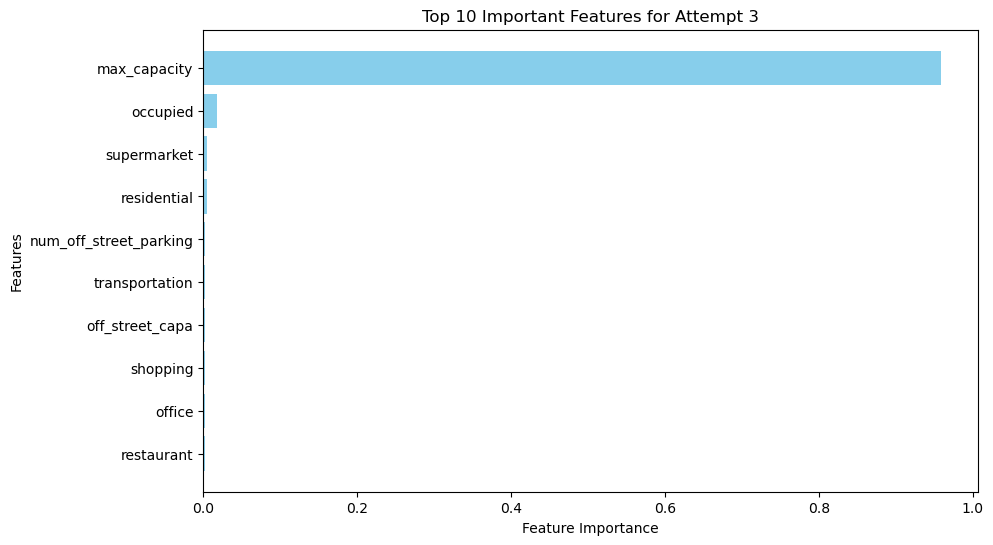

In [70]:
# Attempt 3 - Feature Engineering, Preprocessing and selecting all features
attempt3 = ['max_capacity', 'occupied','tempC', 'windspeedKmph', 'precipMM', 'commercial', 
            'residential', 'transportation', 'schools', 'eventsites', 'restaurant', 'shopping',
                      'office', 'supermarket', 'num_off_street_parking', 'off_street_capa',
                      'day_of_week', 'is_weekend', 'hour']
run_experiment(df, attempt3, 'available', "Attempt 3")

Attempt: Attempt 4
Mean Absolute Error: 1.1653860288243378
Root Mean Squared Error: 2.299110173079787
R-squared: 0.8972196546641568


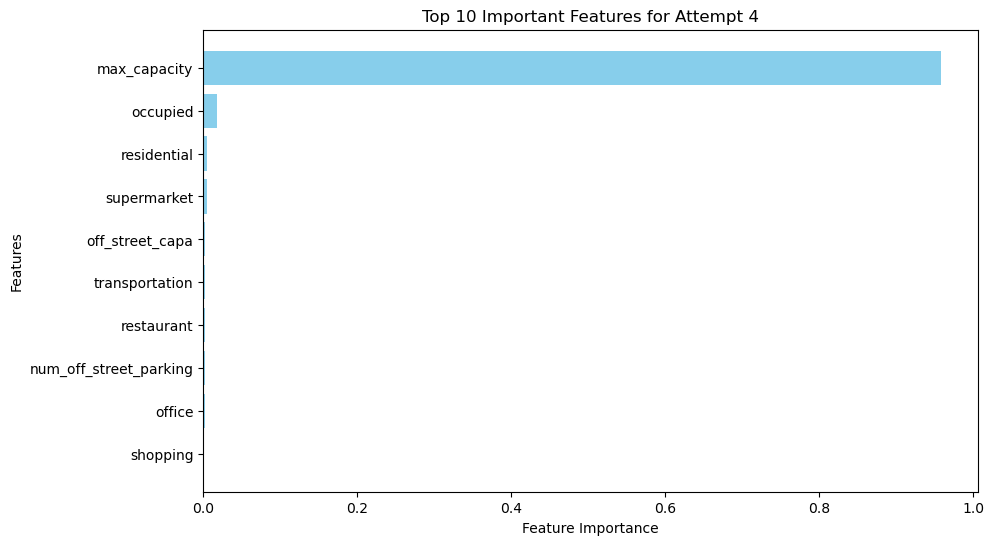

In [71]:
# Attempt 4 - More feature engineering (lag and rolling features : occupied)
df['occupied_lag_1'] = df['occupied'].shift(1)
df['occupied_lag_3'] = df['occupied'].shift(3)
df['occupied_lag_6'] = df['occupied'].shift(6)
df['occupied_rolling_mean_3'] = df['occupied'].rolling(window=3).mean()
df['occupied_rolling_mean_6'] = df['occupied'].rolling(window=6).mean()
df['occupied_rolling_mean_12'] = df['occupied'].rolling(window=12).mean()
df.fillna(0, inplace=True)

attempt4 = ['max_capacity', 'occupied', 'occupied_lag_1', 'occupied_lag_3', 'occupied_rolling_mean_3',
                      'occupied_rolling_mean_6', 'tempC', 'windspeedKmph', 'precipMM', 'commercial', 
                      'residential', 'transportation', 'schools', 'eventsites', 'restaurant', 
                      'shopping', 'office', 'supermarket', 'num_off_street_parking', 'off_street_capa',
                      'day_of_week', 'is_weekend', 'hour']
run_experiment(df, attempt4, 'available', "Attempt 4")

Attempt: Attempt 5
Mean Absolute Error: 1.014532722973189
Root Mean Squared Error: 2.0527633303156416
R-squared: 0.9180652244334556


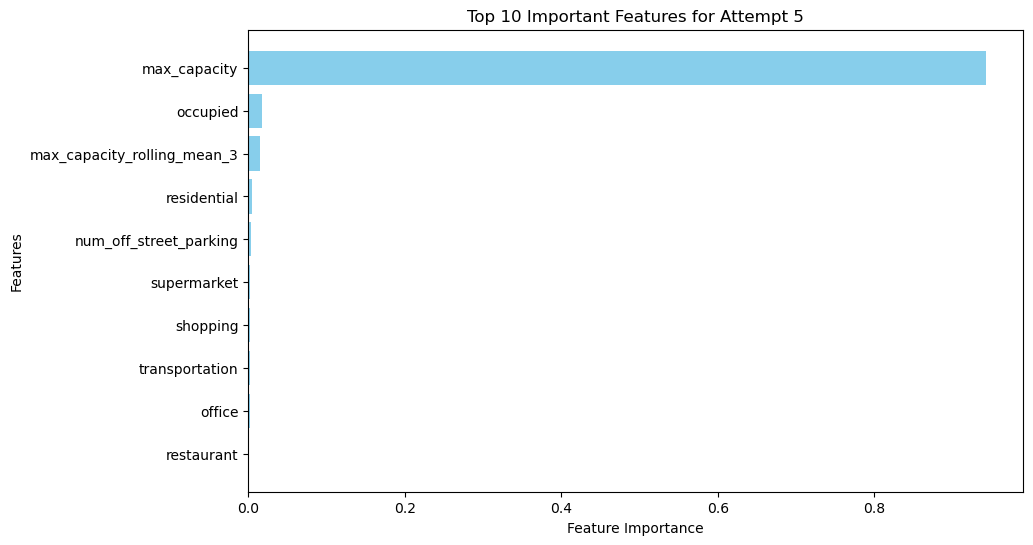

In [72]:
# Attempt 5 - More feature engineering (lag and rolling features : occupied, max_capacity)
df['max_capacity_lag_1'] = df['max_capacity'].shift(1)
df['max_capacity_lag_3'] = df['max_capacity'].shift(3)
df['max_capacity_lag_6'] = df['max_capacity'].shift(6)
df['max_capacity_rolling_mean_3'] = df['max_capacity'].rolling(window=3).mean()
df['max_capacity_rolling_mean_6'] = df['max_capacity'].rolling(window=6).mean()
df['max_capacity_rolling_mean_12'] = df['max_capacity'].rolling(window=12).mean()
df.fillna(0, inplace=True)

attempt5 = ['max_capacity', 'occupied', 'occupied_lag_1', 'occupied_lag_3', 'occupied_rolling_mean_3',
                      'occupied_rolling_mean_6', 'max_capacity_lag_1', 'max_capacity_lag_3', 'max_capacity_rolling_mean_3',
                      'max_capacity_rolling_mean_6',  'tempC', 'windspeedKmph', 'precipMM', 'commercial', 
                      'residential', 'transportation', 'schools', 'eventsites', 'restaurant', 
                      'shopping', 'office', 'supermarket', 'num_off_street_parking', 'off_street_capa',
                      'day_of_week', 'is_weekend', 'hour']
run_experiment(df, attempt5, 'available', "Attempt 5")

In [73]:
# Attempt 6 - More feature engineering (lag and rolling features: occupied, max_capacity) and treating outliers
# Capping outliers at the 99th percentile for precipMM and transportation
precip_cap = df['precipMM'].quantile(0.99)
trans_cap = df['transportation'].quantile(0.99)

df['precipMM'] = np.where(df['precipMM'] > precip_cap, precip_cap, df['precipMM'])
df['transportation'] = np.where(df['transportation'] > trans_cap, trans_cap, df['transportation'])

Attempt: Attempt 6
Mean Absolute Error: 1.0984482152558084
Root Mean Squared Error: 2.2488428796709456
R-squared: 0.9016648615763506


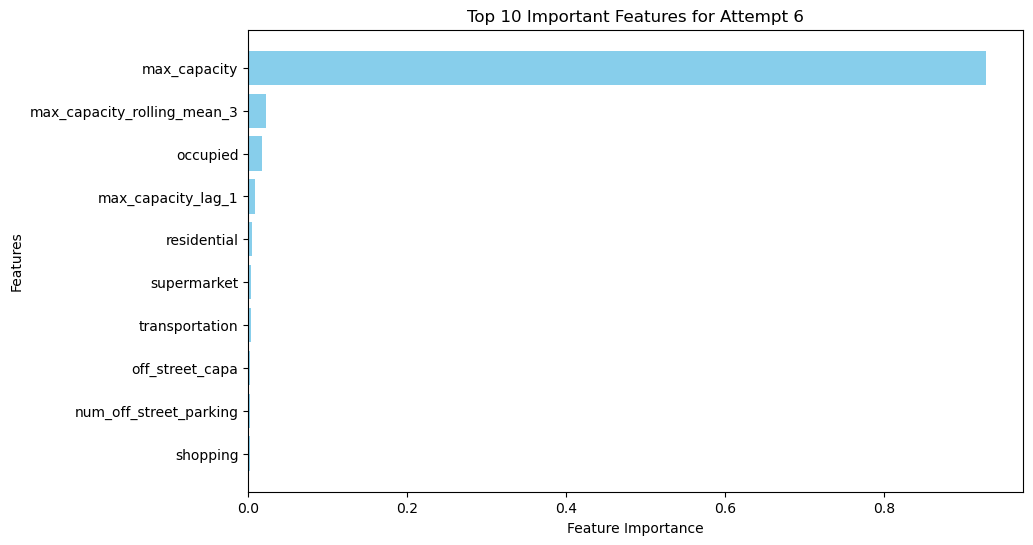

In [74]:
attempt6 = ['max_capacity', 'occupied', 'occupied_lag_1', 'occupied_lag_3', 'occupied_rolling_mean_3',
                      'occupied_rolling_mean_6', 'max_capacity_lag_1', 'max_capacity_lag_3', 'max_capacity_rolling_mean_3',
                      'max_capacity_rolling_mean_6',  'tempC', 'windspeedKmph', 'precipMM', 'commercial', 
                      'residential', 'transportation', 'schools', 'eventsites', 'restaurant', 
                      'shopping', 'office', 'supermarket', 'num_off_street_parking', 'off_street_capa',
                      'day_of_week', 'is_weekend', 'hour']
run_experiment(df, attempt6, 'available', "Attempt 6")

# 6. Results Summary and Visualization

In [75]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Mapping old attempt names to new names
attempt_names = {
    'Attempt 1': 'W/O FE or Preprocessing',
    'Attempt 2': 'FE & Specific Features',
    'Attempt 3': 'FE & All Features',
    'Attempt 4': 'More FE',
    'Attempt 5': 'More FE 2',
    'Attempt 6': 'More FE & Outliers',
}

# Rename attempts
results_df['Attempt'] = results_df['Attempt'].map(attempt_names)
results_df

,Attempt,MAE,RMSE,R2
0,W/O FE or Preprocessing,1.09,2.09,0.92
1,FE & Specific Features,7.33,8.66,-0.46
2,FE & All Features,1.15,2.27,0.90
3,More FE,1.17,2.30,0.90
4,More FE 2,1.01,2.05,0.92
5,More FE & Outliers,1.10,2.25,0.90


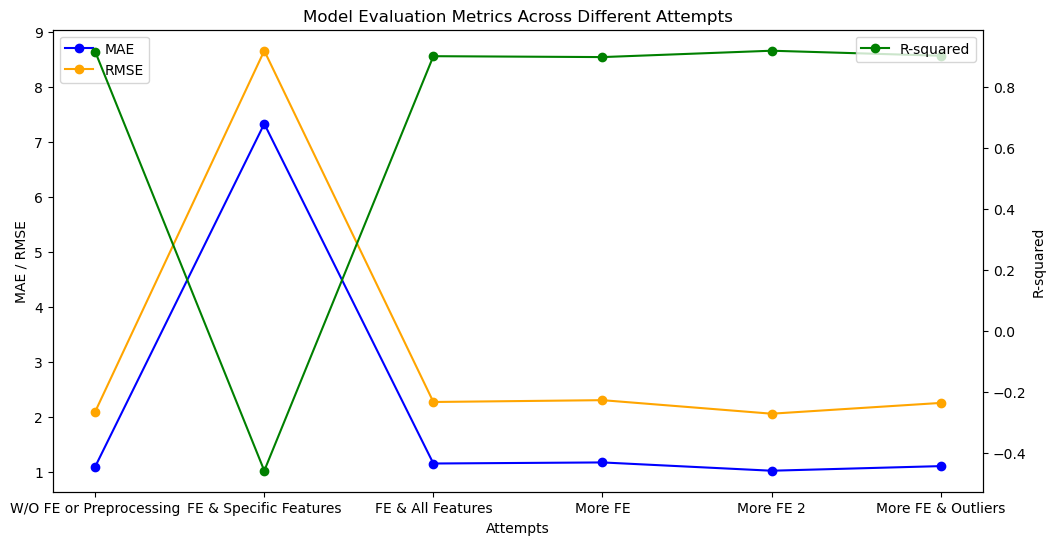

In [76]:
# Plotting the results
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MAE, RMSE, and R-squared on the same plot
ax1.plot(results_df['Attempt'], results_df['MAE'], marker='o', label='MAE', color='blue')
ax1.plot(results_df['Attempt'], results_df['RMSE'], marker='o', label='RMSE', color='orange')
ax2 = ax1.twinx()
ax2.plot(results_df['Attempt'], results_df['R2'], marker='o', label='R-squared', color='green')

# Labeling the plots
ax1.set_xlabel("Attempts")
ax1.set_ylabel("MAE / RMSE")
ax2.set_ylabel("R-squared")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("Model Evaluation Metrics Across Different Attempts")
plt.savefig("evaluation_metrics.png")
plt.show()